# **CSCA 5632 Unsupervised Project**

https://github.com/lsiver/ml2project
<hr>

## **Project Description**
I will attempt to use unsupervised modelling methods to cluster songs into their respective genres based on the lyrics. Hopefully, songs in the same genre share enough similarities in their lyrics that they will be effectively clustered into groups that match their hidden genre labels. The methods used will be Non-Negative Matrix Factorization (NMF), KMeans, and Latent Dirichlet Allocation (LDA). A supervised method, Logistic Regression, will also be used to compare results against the unsupervised methods.

A lot of songs share common words and some genres are not clean-cut separate from each other (Rock/Metal, RnB/Rap, etc), so this is not an easy task. It will be interesting to see how well this task can be accomplished with only the song lyrics and which unsupervised methods work better.

**Goal**: Create an unsupervised model with a decent accuracy in clustering songs based on their lyrics into their respective genres (hidden labels the algorithm does not see, used for validation)

<hr>

In [363]:
import time
import re
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine
from scipy.stats import mode
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,roc_auc_score, roc_curve,accuracy_score, classification_report)
from sklearn.metrics.pairwise import cosine_similarity
# %matplotlib inline 

## Data Source

The data was taken from two sources. The first file used, `msd_tagtraum_cd2c.cls` contains the genres for each track and was taken from www.tagtraum.com. These labels were generated based on Last.fm, top-MAGD, and beaTunes Genre Dataset data. This is a 4.6 MB size file with 191,409 entries and 2 features (trackID and genre).

The second file used is a database file `mxm_dataset.db` taken from www.musixmatch.com in collaboration with www.millionsongdataset.com. This is a very large file (2.384 GB). This file is given as a database and contains two tables. The first table, `words` will not be used. The second table `lyrics` is important for the work in this project. This table has 19,045,332 rows/entries and 5 columns: `track_id`, `mxm_tid`, `word`, `count`, and `is_test`. `track_id`, `word`, and `count` will be useful. The `track_id` in this database matches up with the `track_id` in the `msd_tagtraum_cd2c.cls` file. `word` is a word that appears in the `track_id` and then `count` is how many times that word appears in that song. `track_id` has non-unique values due to how the file structure is designed. Each individual word for each track requires its own entry.

Both of the above files are taken from public available sources and are available for research and machine learning purposes. The goal is to be able to have at least 1000 songs per genre modelled and these datasets allow that. More discussion about this is in the next section.

Due to the lyrics of songs being copyrighted, it is a tricky issue sourcing the full lyrics of songs online. Scraping it from online sources is also frowned upon (such as Genius). Therefore, this dataset of "lyrics" is an abridged form presented as a bag of words that is respectful to copyright but is supposed to allow machine learning tasks.

<hr>

#### *References for Datasets*

Bertin-Mahieux, Thierry, Daniel P. W. Ellis, Brian Whitman, and Paul Lamere. "The Million Song Dataset." *Proceedings of the 12th International Conference on Music Information Retrieval (ISMIR 2011)*, 2011.

Hendrik Schreiber. Improving Genre Annotations for the Million Song Dataset. *In Proceedings of the 16th International Society for Music Information Retrieval Conference (ISMIR)*, pages 241-247, Málaga, Spain, Oct. 2015. 

<hr>

## Data Pre-Preprocessing
I am calling this section **"Pre-Preprocessing"** because the data is not yet in one single dataset file and it will require a couple of steps to get it into working shape. The data comes in two parts and it will require some extra effort to make the data readily usable. The first file is `msd_tagtraum_cd2c.cls`. This file has two features, `track_id` which is a common id used across different data files for this sort of task and `genre` which is the music genre the track ID belongs to. The different `genre`'s are:

-  Rock
-  Rap
-  Latin
-  Jazz
-  Electronic
-  Pop
-  Metal
-  RnB
-  Country
-  Reggae
-  Blues
-  Folk
-  Punk
-  World
-  New Age

The other dataset, `mxm_dataset.db`, contains the actual lyrics we need. Note, the lyrics are a shortened form presented as a "bag of words". Due to copyright, they cannot be printed in full in order. This obviouslly means some machine learning methods and techniques cannot be used. Some methods make use of the order of words appearing together to make connections and inferences but this is not possible with this dataset.

In order to compile the data into an easier to use format, I will take ~5000 `track_id`'s from each `genre` from the `msd_tagtraum_cd2c.cls` file and create a new dataframe object with those properties. Then for each `track_id` I will create a field that will store each word that appears in that track_id multiplied by how many times it appeared as calculated by `count` from the `mxm_dataset.db` file.

In [364]:
genre_df = pd.read_csv('msd_tagtraum_cd2c.cls',sep='\t',comment='#',header=None,names=['track_id', 'genre'])
#print(genre_df.head())
#print(genre_df["genre"].unique())

In [365]:
FLAG = 0
if FLAG == 1:
    #sample ~6000 per genre
    undersampled_genres = genre_df.groupby('genre', group_keys=False).apply(lambda g: g.sample(n=6000, random_state=42) if len(g) >= 6000 else g,include_groups=False)
    #grab their respective track_ids
    undersampled_trackids = undersampled_genres['track_id'].tolist()
    
    #open the sql database
    conn = sqlite3.connect('mxm_dataset.db')
    
    def sub_partition(seq,size):
        for pos in range(0,len(seq),size):
            yield seq[pos:pos+size]
    
    #Pulling the information from the sql database in sub-partition amounts
    part_df = []
    partition_size = 500
    for partition in sub_partition(undersampled_trackids,partition_size):
        sep = ','.join('?' for _ in partition)
        sql_query = f"SELECT track_id, word, count FROM lyrics WHERE track_id IN ({sep})"
        partition_df = pd.read_sql_query(sql_query,conn,params=partition)
        part_df.append(partition_df)
        
    all_lyrics_df = pd.concat(part_df,ignore_index=True)
    
    #create a single string for each word * how many times it appears
    def word_multiplier(inputs):
        words = []
        for _, row in inputs.iterrows():
            words.extend([row['word']]*row['count'])
        return ' '.join(words)
    
    #now need to join all of the texts that have the same track_id
    text_lyrics_all = all_lyrics_df.groupby('track_id', group_keys=False).apply(word_multiplier, include_groups=False).reset_index(name='lyrics')
    
    #now, combine the lyrics df with the genre df from earlier
    df_final = pd.merge(text_lyrics_all,undersampled_genres,on='track_id',how='inner')
    
    #now to grab the genres again and add it to the lyrics df
    track_to_genre = genre_df.set_index('track_id')['genre'].to_dict()
    text_lyrics_all['genre'] = text_lyrics_all['track_id'].map(track_to_genre)
    
    #final dataframe
    df_final = text_lyrics_all
    
    print(df_final.head())

With this done, I am going to save the data frame as a new csv file which during model development I will refer to and import my data from. Re-calculating the above over and over again is not necessary and it is slow. This file will be saved as `df_final.csv`.

In [366]:
if FLAG == 1:
    df_final.to_csv('df_final.csv', index=False)

In [367]:
df = pd.read_csv('df_final.csv')
print(df.head())
print(df.info())

             track_id                                             lyrics  \
0  TRAAAED128E0783FAB  i i i i i i i i i i i i i i i i i i i i i i i ...   
1  TRAAAGF12903CEC202  en e end du du et fine som n ei og så mot mot ...   
2  TRAACER128F4290F96  i i i i the the the the the the the the the th...   
3  TRAADFO128F92E1E91  i i i i i i i i i i i i i i i i i i i i i i i ...   
4  TRAADNA128F9331246  i i i i the the the the the the the the the th...   

    genre  
0    Jazz  
1     Pop  
2   Metal  
3  Reggae  
4   Blues  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29661 entries, 0 to 29660
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   track_id  29661 non-null  object
 1   lyrics    29661 non-null  object
 2   genre     29661 non-null  object
dtypes: object(3)
memory usage: 695.3+ KB
None


In [368]:
print(df['genre'].unique())

['Jazz' 'Pop' 'Metal' 'Reggae' 'Blues' 'Punk' 'Country' 'Rock' 'RnB'
 'Folk' 'Rap' 'Electronic' 'Latin' 'New Age' 'World']


## Data Preprocessing/Cleaning
Now we can begin processing the data in earnest. The *created* `df_final.csv` is 31.3 MB in size. The data has 29661 entries and 3 features. The features are `track_id` which is a unique id for each song, `lyrics` which is bag-of-words-esque representation of the lyrics for the song (due to copyright issues, websites avoid hosting the word-for-word lyrics in their datasets), and `genre` which is the genre that the song belongs to.

In [369]:
print(df.head(),'\n')
print(f'{df.shape[0]} Rows and {df.shape[1]} Columns')
print(df['lyrics'].isnull().any())

             track_id                                             lyrics  \
0  TRAAAED128E0783FAB  i i i i i i i i i i i i i i i i i i i i i i i ...   
1  TRAAAGF12903CEC202  en e end du du et fine som n ei og så mot mot ...   
2  TRAACER128F4290F96  i i i i the the the the the the the the the th...   
3  TRAADFO128F92E1E91  i i i i i i i i i i i i i i i i i i i i i i i ...   
4  TRAADNA128F9331246  i i i i the the the the the the the the the th...   

    genre  
0    Jazz  
1     Pop  
2   Metal  
3  Reggae  
4   Blues   

29661 Rows and 3 Columns
False


### **Checking for null values**

In [370]:
print("Checking null values in the 'lyrics' column: ",df['lyrics'].isnull().sum())
print("Checking null values in the 'genre' column: ", df['genre'].isnull().sum())

Checking null values in the 'lyrics' column:  0
Checking null values in the 'genre' column:  0


There are not any null values in "genre" or "lyrics" column. That is mostly expected since the data was hand-constructed but I suppose the original database file or the genre file could have had null values in them and that would have been propagated into the created data file.

### **Converting words to Stemmed Form**

To increase the accuracy of the unsupervised task, many words are converted to a similar word. I.e., "runnin'", "running", will both be converted to "running". This is done in order to combine words with very similar meaning into one word which will allow the different tools (such as `TfidfTransformer`) to recognize those words as being equal and then the word count will use them together. It would not make sense to give different meaning to crying and cryin' just because of typing differences when the lyrics were converted from audio to text. *With a lot of data it might make sense to keep the words separately if they were annotated correctly since it could imply an accent or pronunciation which could feasibly be used to separate a song into a genre*

And for appearances, a couple of explicitives were converted into a different form that is more presentable.

|Full|Stemmed|
|-|-|
|Cryin'|Cryin|
|Crying|Cryin|
|Lovin'|Lovin|
|Loving|Lovin|
|etc...|

A standard stemmed form list of words is used in the conversion. The conversion is done below.

In [371]:
stem_map = {}
with open('stemmed_words.txt', 'r', encoding='utf-8') as f:
    for line in f:
        stemmed, full = line.strip().split('<SEP>')
        stem_map[full] = stemmed
def apply_word_conversion(text):
    words = text.split()
    return ' '.join(stem_map.get(word, word) for word in words)
df['lyrics'] = df['lyrics'].apply(apply_word_conversion)

### **Removing Entries with Nonstandard Characters**

The data contains lyrics from multiple languages and sometimes contains just odd, non-Ascii characters (**â,€,œ**, etc). Although the data is MOSTLY in english, there are some outliers. Any entries with non-standard characters will be removed. If the entry is in the genre "Latin", then this operation will be ignored. I do not want to remove entries with valid spanish characters (á, é, í, ó, ú). Other languages that appear or if there were mistakes in the lyric tabulation will be removed if they are using non-standard characters. Mostly need to stick with english for this processing task since I can't easily tabulate the representation of each language in the data and keeping in foreign languages may inflate the accuracy for certain genres if that language appears significantly more in that genre. I.e., if there's a lot of swedish in the metal category but none in the rap category than the model will easily categorize songs with swedish words as "metal" without giving much meaning to the words itself. Preferably you would also want a lot of rap in swedish as well so the trained model / clustering has to consider the meaning of each word and then cluster it.

The non-Ascii characters are tabulated for each genre below and then removed in a second step.

In [372]:
def count_odd_chars(text):
    return sum(1 for char in text if ord(char) > 127)
df['non_ascii_count'] = df['lyrics'].apply(count_odd_chars)
genre_non_ascii = df.groupby('genre')['non_ascii_count'].sum().sort_values(ascending=False)
print("Total number of non-standard characters in each genre \n",genre_non_ascii)

Total number of non-standard characters in each genre 
 genre
Latin         7018
Pop           6034
Rap           5390
Rock          1974
Reggae        1946
Folk          1120
RnB            954
Metal          879
Jazz           828
World          813
Punk           706
Country        605
Electronic     334
Blues          154
New Age         32
Name: non_ascii_count, dtype: int64


In [373]:
def contains_odd_chars(text):
    return bool(re.search(r'[^\x00-\x7F]',text))
df = df[~df['lyrics'].apply(contains_odd_chars) | (df['genre'] == 'Latin')].reset_index(drop=True)

In [374]:
def count_odd_chars(text):
    return sum(1 for char in text if ord(char) > 127)
df['non_ascii_count'] = df['lyrics'].apply(count_odd_chars)
genre_non_ascii = df.groupby('genre')['non_ascii_count'].sum().sort_values(ascending=False)
print("Total number of non-standard characters in each genre \n",genre_non_ascii)

Total number of non-standard characters in each genre 
 genre
Latin         7018
Country          0
Blues            0
Electronic       0
Folk             0
Jazz             0
Metal            0
New Age          0
Pop              0
Punk             0
Rap              0
Reggae           0
RnB              0
Rock             0
World            0
Name: non_ascii_count, dtype: int64


# **Exploratory Data Analysis**

## Data Description
The data is a single table format with each row representing a song. Each song is labelled under one genre: Rock, Rap, Latin, Jazz, Electronic, Pop, Metal, RnB, Country, Reggae, Blues, Folk, Punk, World, New Age.

- **Number of rows (entries):** 29662
- **Number of columns (features):** 3 - `trackID`, `lyrics`, `genre`
- **Size:** 31.3 MB



### Data Distribution

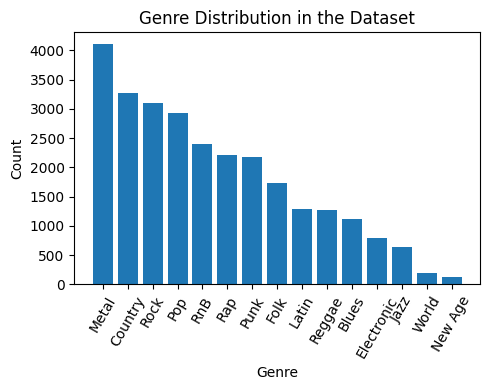

In [375]:
genres = df["genre"].value_counts()
####
plt.figure(figsize=(5,4))
plt.bar(genres.index,genres.values)
plt.xticks(rotation=60)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Distribution in the Dataset')
plt.tight_layout()
plt.show()

<hr>
The distribution of the genres is very skewed. It is not necessary to oversample or adjust for this skew. Oversampling in an unsupervised problem such as this one could distort the natural frequency of genres in the data, lead the model to overfit noise from less frequent genres, and could create artificial clusters that do not actually exist. The skewwing could be a problem for supervised methods but this project is focused on unsupervised methods.

Also, I do not think a reasonable model can be developed with less than 500 entries. `World` and `New Age` will be dropped. 

In [376]:
df = df[~df["genre"].isin(["New Age", "World"])]
#df = df[~df["genre"].isin(["RnB","Punk","Folk","Reggae","Blues","Electronic","Jazz"])]
#df = df[~df["genre"].isin(["Pop","Latin"])]

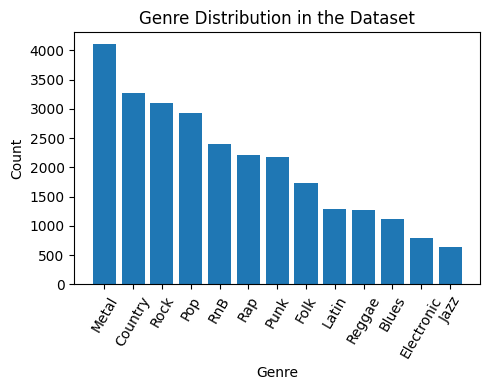

In [377]:
genres = df["genre"].value_counts()
####
plt.figure(figsize=(5,4))
plt.bar(genres.index,genres.values)
plt.xticks(rotation=60)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Distribution in the Dataset')
plt.tight_layout()
plt.show()

### Vectorizing the Data and Data Preparation
The scikit learn `CountVectorizer()` package can take in lists of words and count the frequency of each word. This essentially allows us to vectorize / turn the lyrics into a matrix which we will need later when doing a matrix factorization and other methods. First, we will check the most frequent words of ALL the lyrics combined using the `CountVectorizer()` package.

Additionally, we will show the top words for all lyrics and then each of the lyrics by genre. These common words *may* need to be removed if we cannot generate a model with good accuracy. 

These steps above help improve the accuracy of the model and reduces computation. 

In [378]:
genre_dict = df.groupby("genre")["lyrics"].apply(list).to_dict()

In [379]:
all_lyrics = list(df["lyrics"])

In [380]:
vectorizer = CountVectorizer()
W = vectorizer.fit_transform(all_lyrics)
word_counts = np.asarray(W.sum(axis=0)).flatten()
word_freq = dict(zip(vectorizer.get_feature_names_out(),word_counts))
sortedwords = sorted(word_freq.items(),key=lambda item: item[1], reverse=True)
top_word = 20
top_words_all = sortedwords[:top_word]

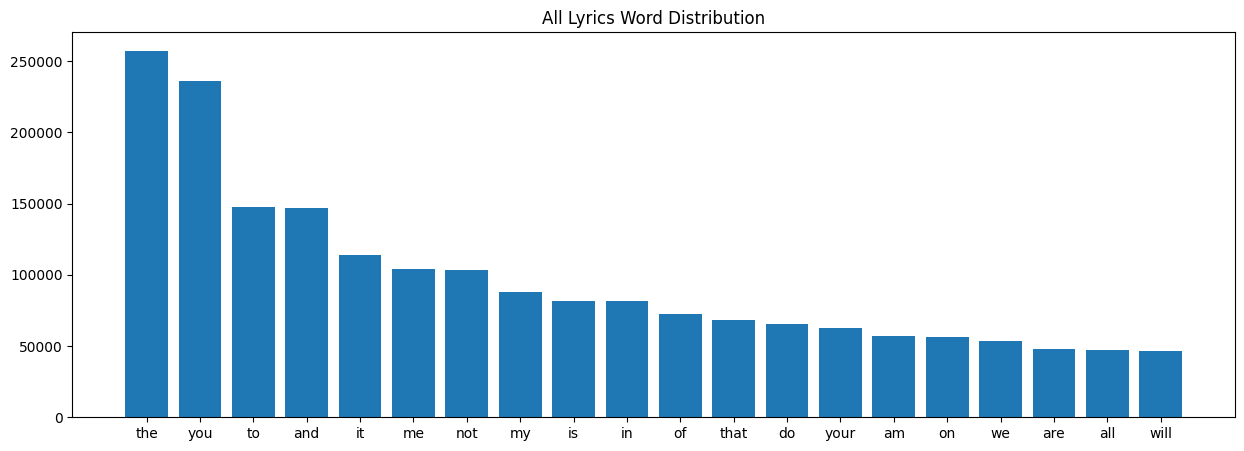

In [381]:
words, counts = zip(*top_words_all)
plt.figure(figsize=(15,5))
plt.bar(words,counts)
plt.title("All Lyrics Word Distribution")
plt.show()

<hr>

The top 20 words are shown above. It is difficult to say whether these words add any value to the unsupervised problem. They probably do not. The `CountVectorizer()` package includes a standard **"stop words"** package which will exlude these from its analysis. We will show the results of the top words below with this common option used.

In [382]:
vectorizer = CountVectorizer(stop_words='english')
W = vectorizer.fit_transform(all_lyrics)
word_counts = np.asarray(W.sum(axis=0)).flatten()
word_freq = dict(zip(vectorizer.get_feature_names_out(),word_counts))
sortedwords = sorted(word_freq.items(),key=lambda item: item[1], reverse=True)
top_word = 20
top_words = sortedwords[:top_word]

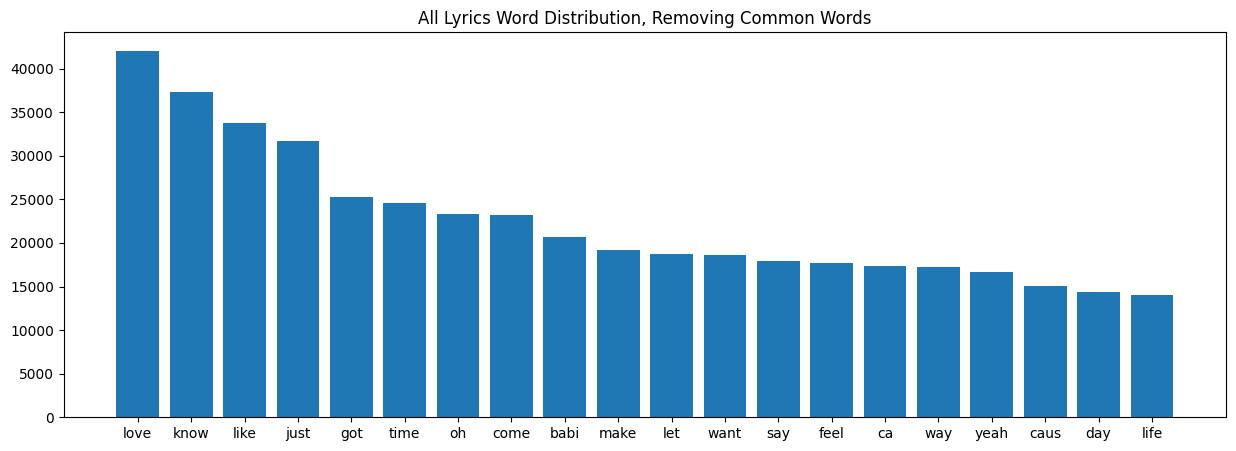

In [383]:
words, counts = zip(*top_words)
plt.figure(figsize=(15,5))
plt.bar(words,counts)
plt.title("All Lyrics Word Distribution, Removing Common Words")
plt.show()

The above is a reasonable list of words that have more meaning than "the","to","him", etc. Below is the top 20 words for each of the genres categories.

In [384]:
#custom_stopwords = list(ENGLISH_STOP_WORDS.union({'love'}))
custom_stopwords = 'english'

In [385]:
top_words_by_genre = {}
for genre, lyrics in genre_dict.items():
    vectorizer = CountVectorizer(stop_words=custom_stopwords)
    W = vectorizer.fit_transform(lyrics)
    word_counts = np.asarray(W.sum(axis=0)).flatten()
    word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))
    sortedwords = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)
    top_words_by_genre[genre] = sortedwords[:top_word]

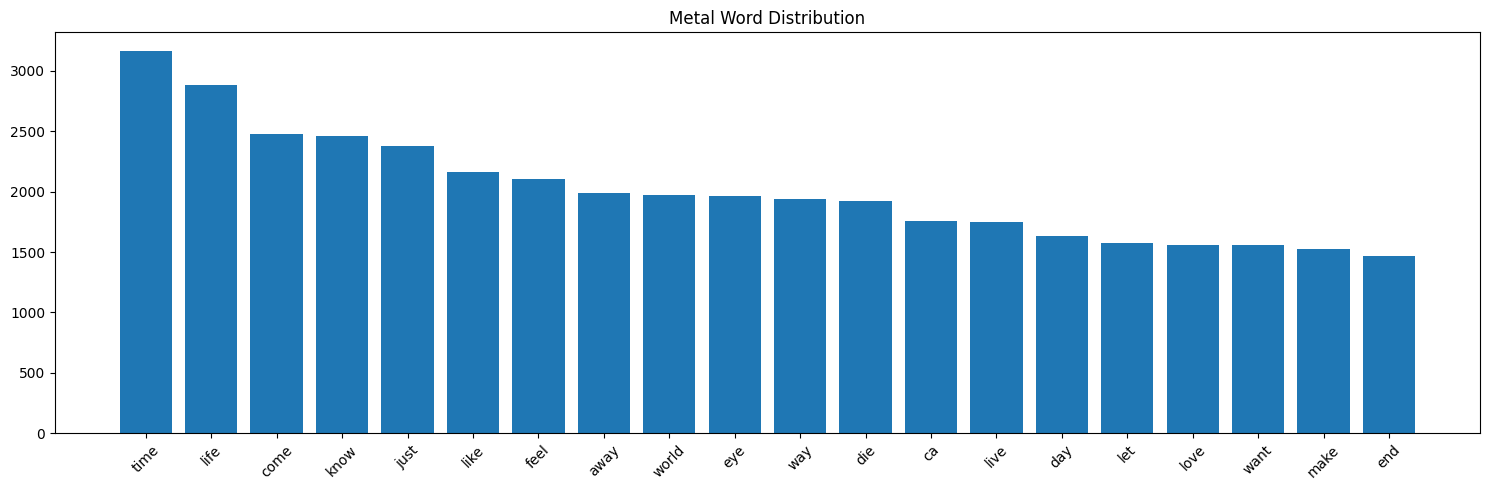

In [386]:
def plotter(words,counts,title):
    plt.figure(figsize=(15,5))
    plt.bar(words,counts)
    plt.xticks(rotation=45)
    plt.title(f"{title} Word Distribution")
    plt.tight_layout()
    plt.show()
words, counts = zip(*top_words_by_genre["Metal"])
plotter(words, counts, "Metal")

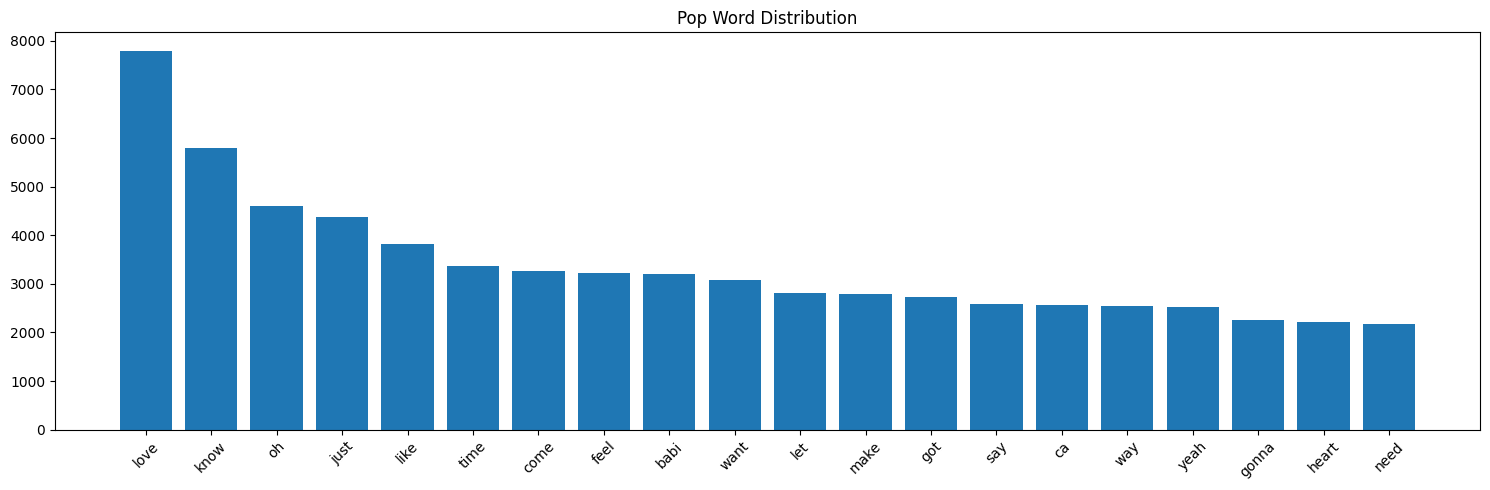

In [387]:
words, counts = zip(*top_words_by_genre["Pop"])
plotter(words, counts, "Pop")

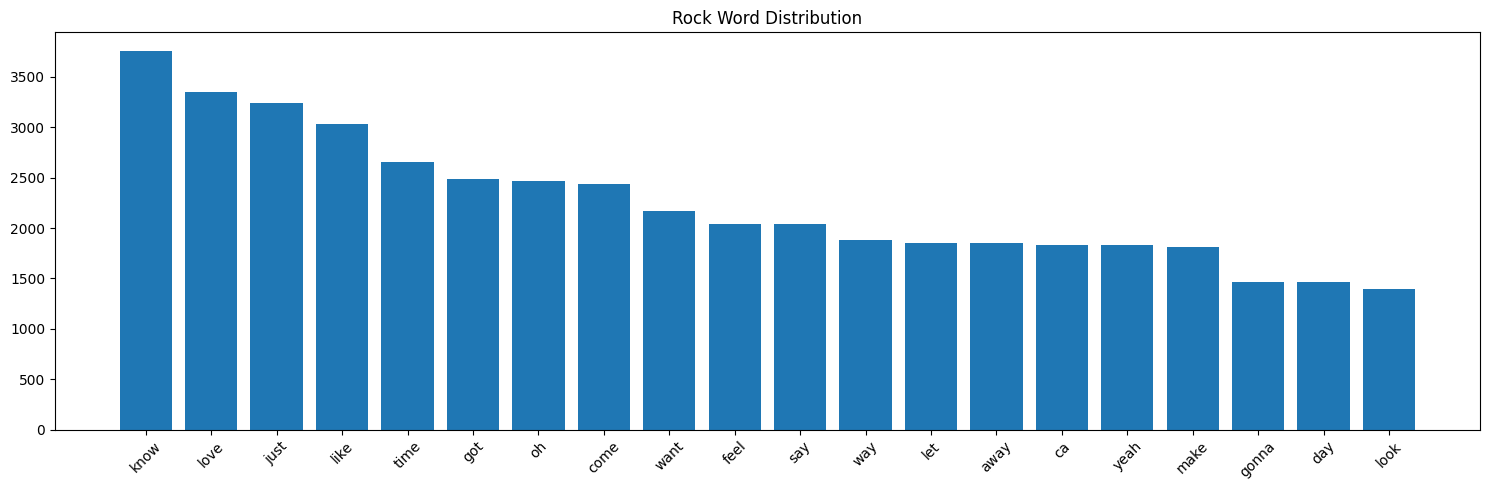

In [388]:
words, counts = zip(*top_words_by_genre["Rock"])
plotter(words, counts, "Rock")

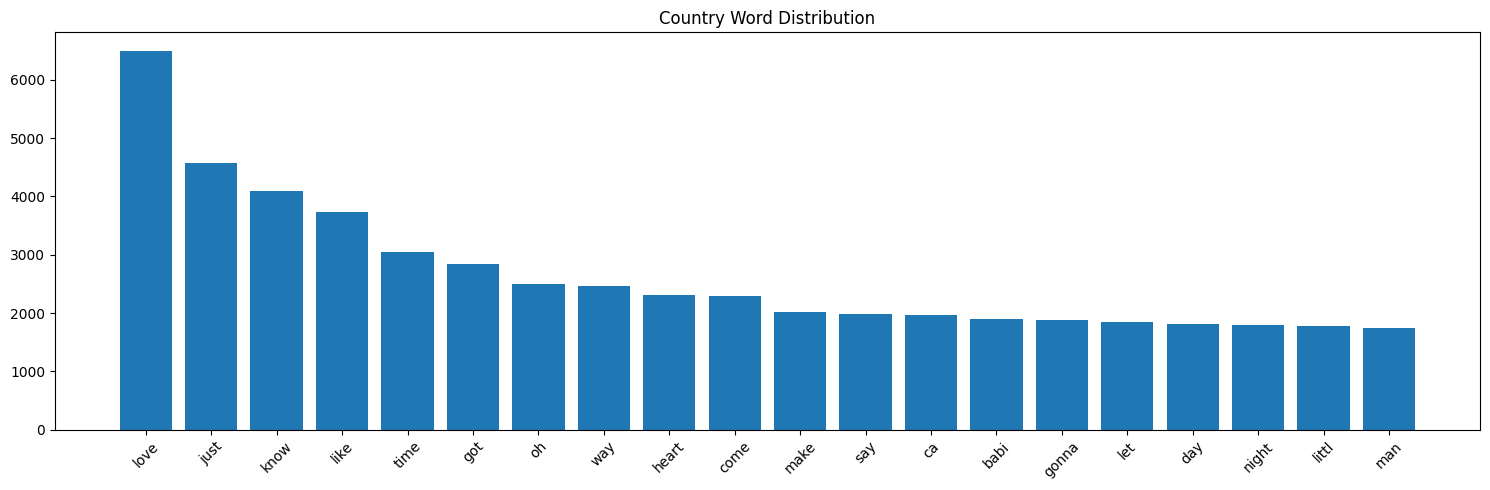

In [389]:
words, counts = zip(*top_words_by_genre["Country"])
plotter(words, counts, "Country")

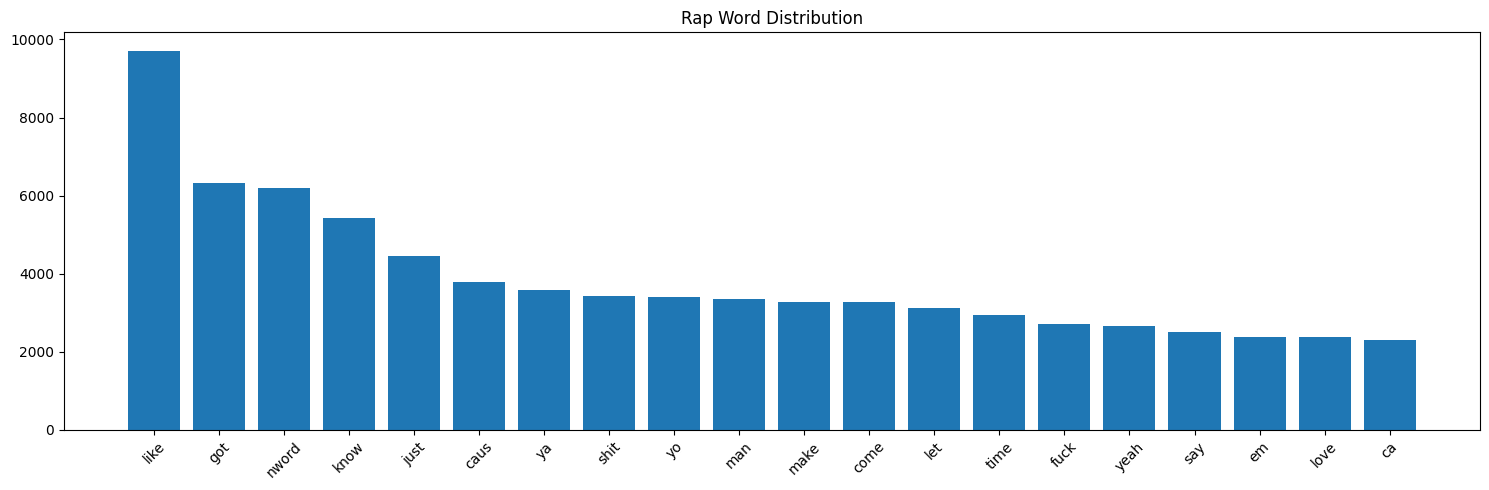

In [390]:
words, counts = zip(*top_words_by_genre["Rap"])
plotter(words, counts, "Rap")

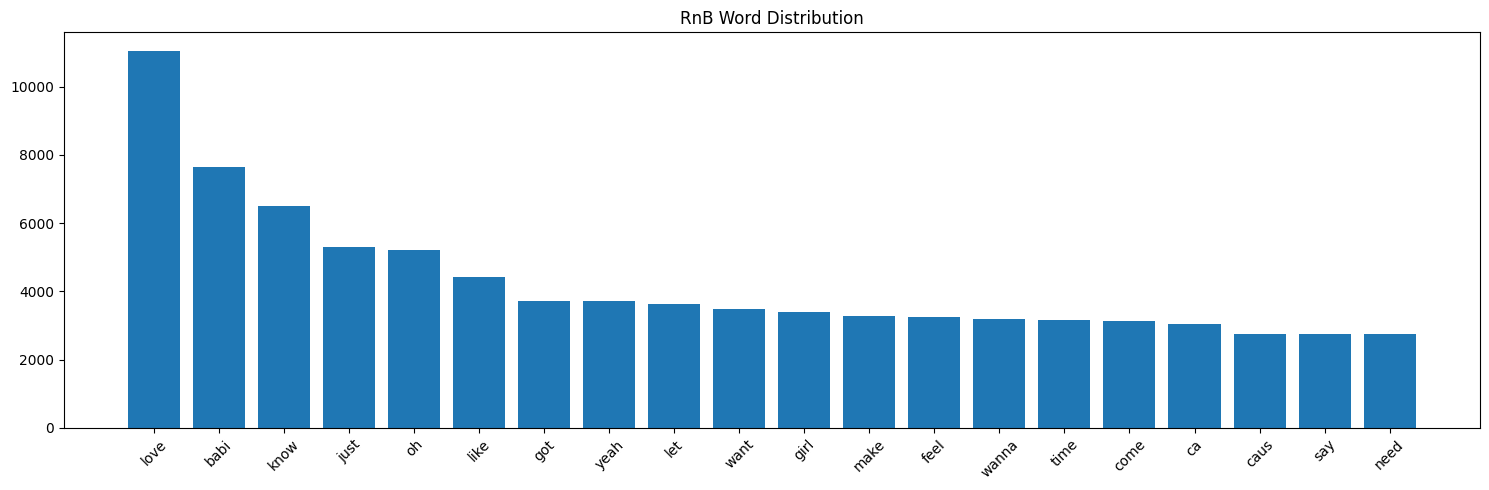

In [391]:
words, counts = zip(*top_words_by_genre["RnB"])
plotter(words, counts, "RnB")

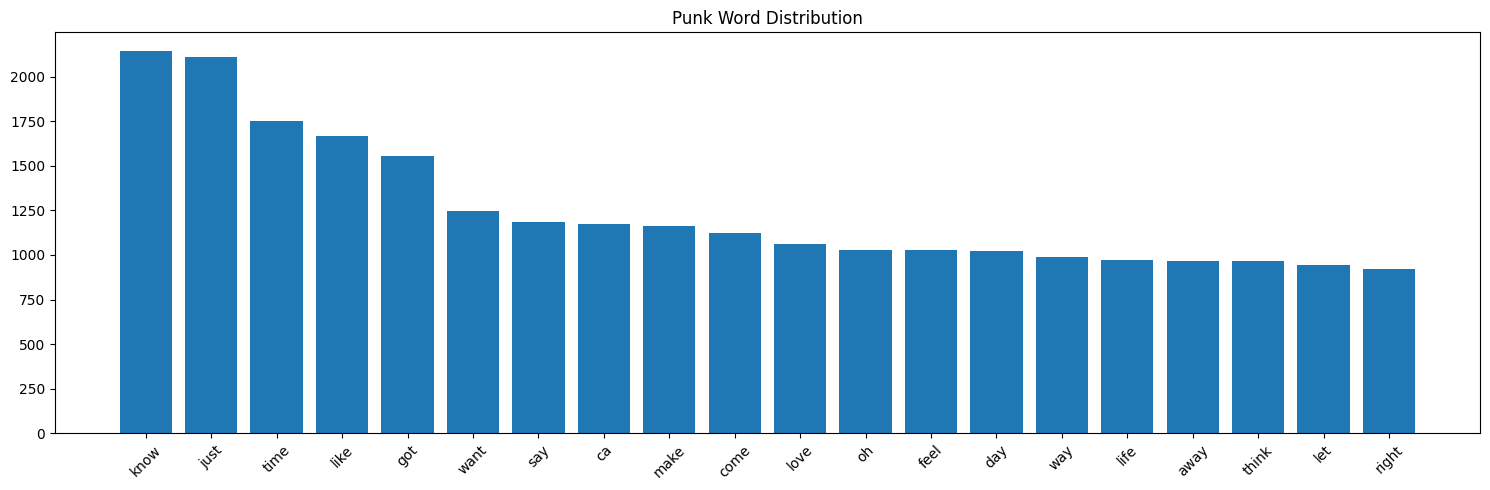

In [392]:
words, counts = zip(*top_words_by_genre["Punk"])
plotter(words, counts, "Punk")

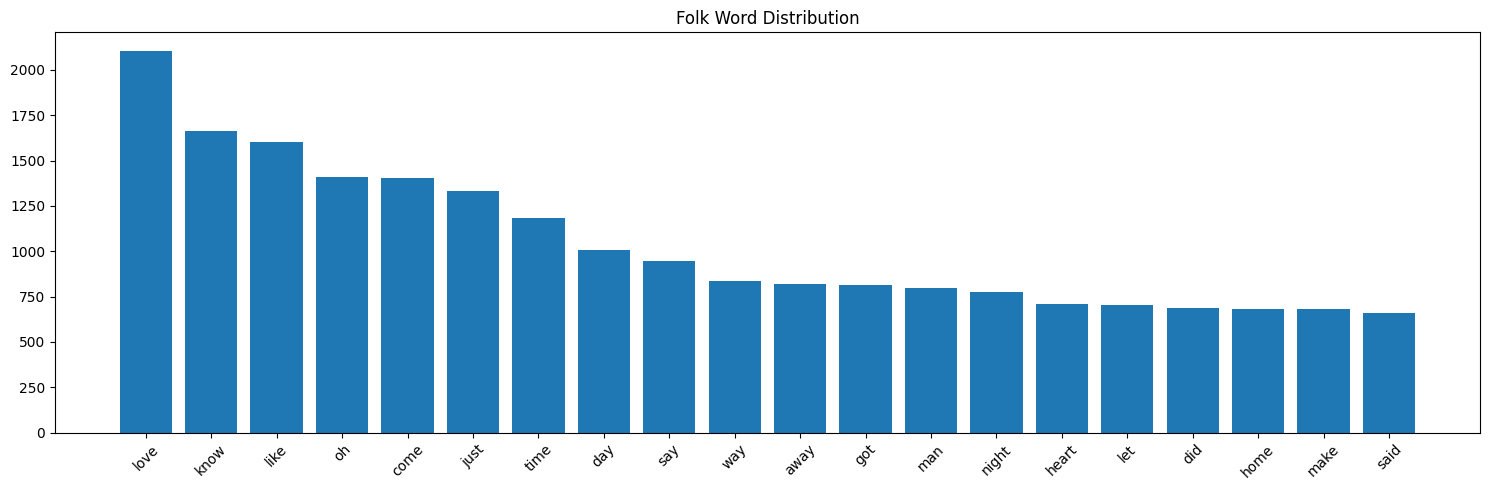

In [393]:
words, counts = zip(*top_words_by_genre["Folk"])
plotter(words, counts, "Folk")

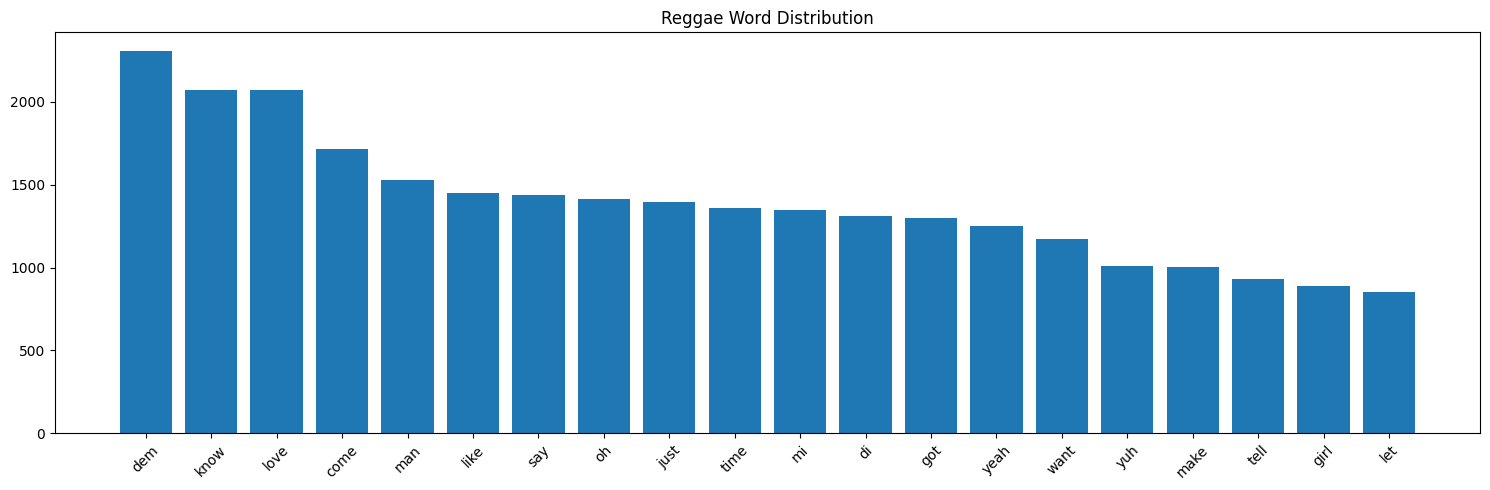

In [394]:
words, counts = zip(*top_words_by_genre["Reggae"])
plotter(words, counts, "Reggae")

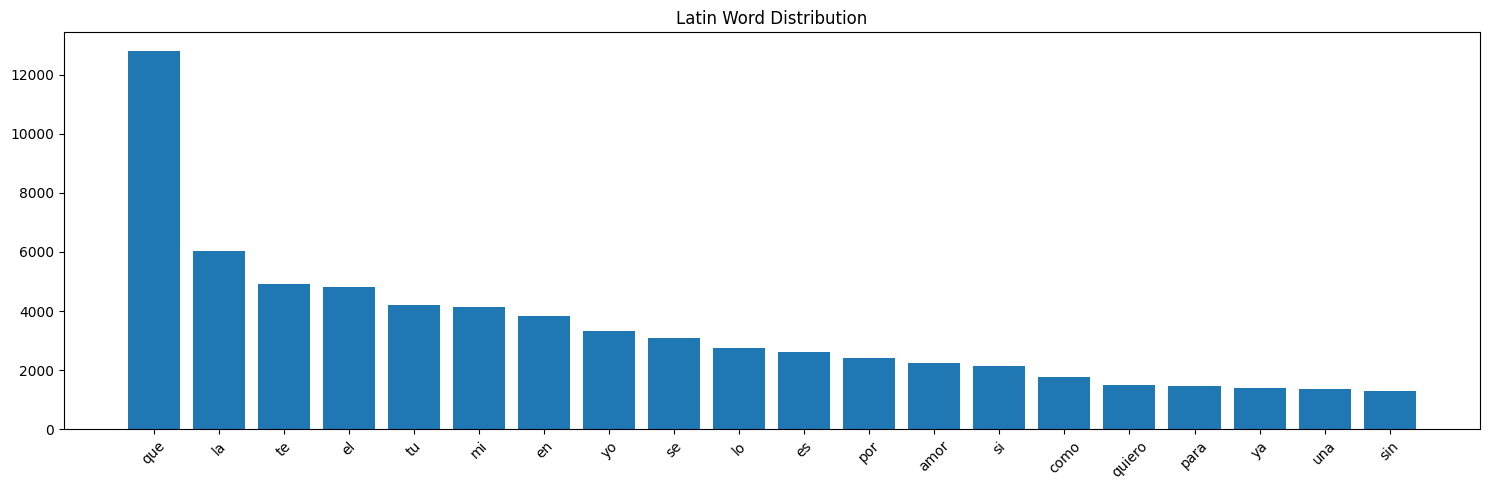

In [395]:
words, counts = zip(*top_words_by_genre["Latin"])
plotter(words, counts, "Latin")

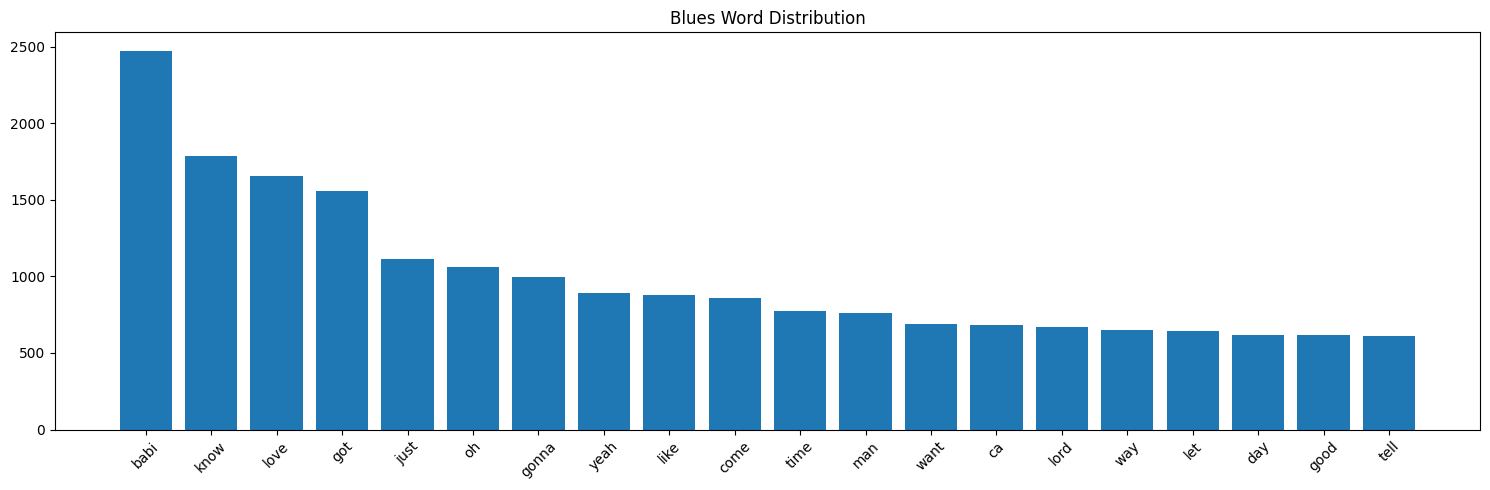

In [396]:
words, counts = zip(*top_words_by_genre["Blues"])
plotter(words, counts, "Blues")

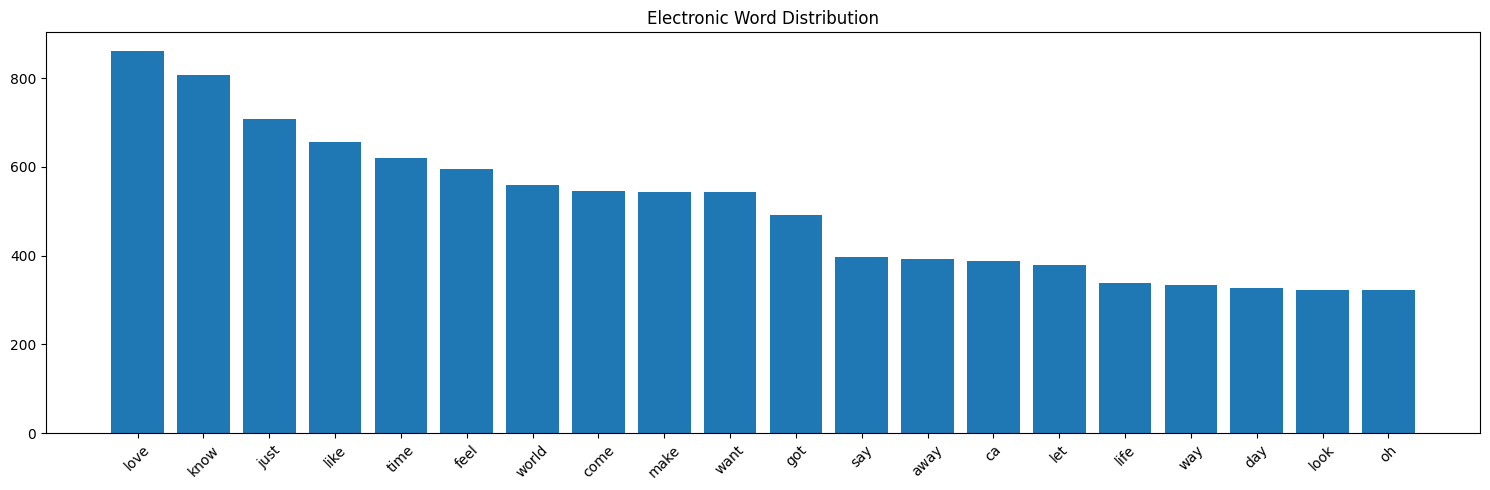

In [397]:
words, counts = zip(*top_words_by_genre["Electronic"])
plotter(words, counts, "Electronic")

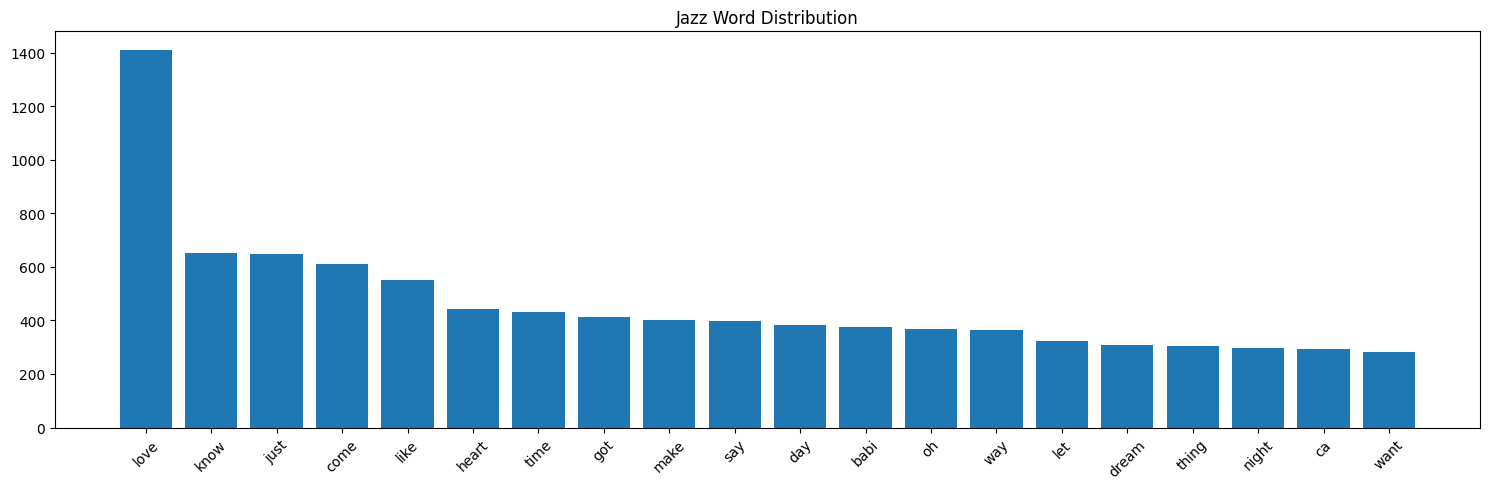

In [398]:
words, counts = zip(*top_words_by_genre["Jazz"])
plotter(words, counts, "Jazz")

### Similarity Between Genres

Before doing any model building, it will be interesting to view the similarity between the genres. This will give us a decent indicator of how difficult the clustering problem will be since if the similarity is high it will be hard to classify genres separate from each other. The cosine similarity is calculated for each genre x genre pairing and shown below.

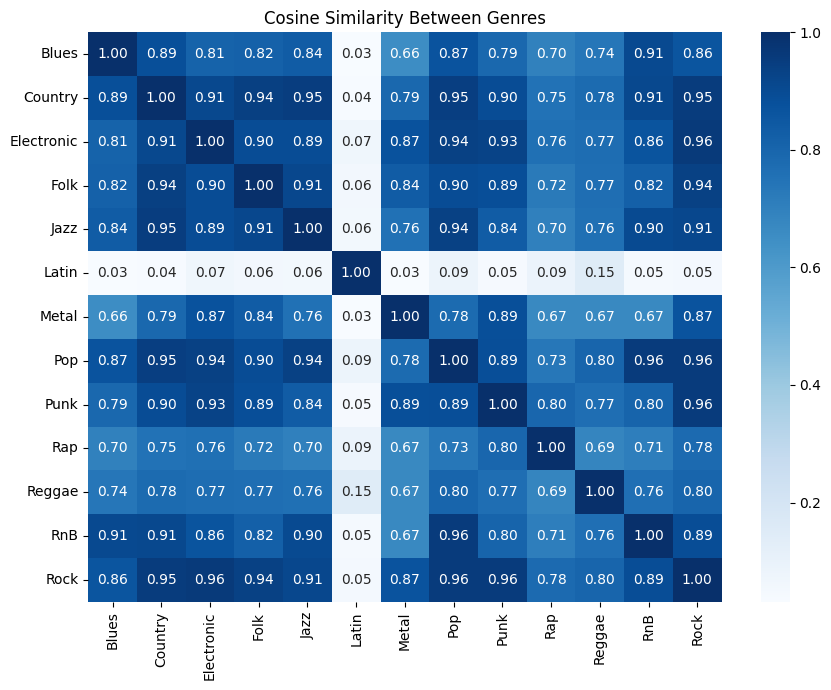

In [399]:
genre_all_texts = df.groupby('genre')['lyrics'].apply(lambda texts: ' '.join(texts)).reset_index()

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english') 
genre_vecs = vectorizer.fit_transform(genre_all_texts['lyrics']) 

#cosine matrix calculation
simi_matrix = cosine_similarity(genre_vecs)


genre_labels = genre_all_texts['genre'].tolist()

plt.figure(figsize=(9, 7))
sns.heatmap(simi_matrix, xticklabels=genre_labels, yticklabels=genre_labels,cmap='Blues', annot=True, fmt=".2f")
plt.title("Cosine Similarity Between Genres")
plt.tight_layout()
plt.show()

<hr>

As shown above, separating genre clusters is going to be a difficult task. There is a high similarity between ALL of the genres except for **Latin** (and of course this is due to most of the lyrics being a different language so that immediately makes the clustering task simple). This similarity was calculated after using a Tfidf-Transformer as well which gives more weight to rare and unique words that appear in each genre and devalues common words that are not as selective. So this is sort of a best-case scenario.



<hr>

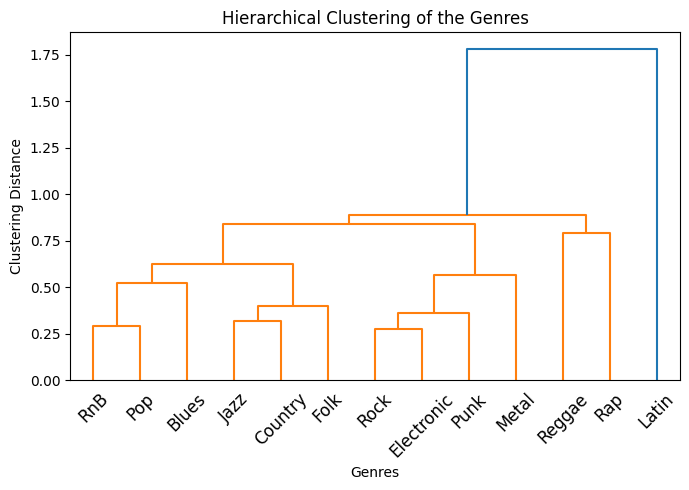

In [400]:
genres = genre_all_texts['genre'].tolist()
texts = genre_all_texts['lyrics'].tolist()
#tfidf weighting
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(texts).toarray()

#hierarchical clustering/dendrogram
linked = linkage(X, method='ward')

plt.figure(figsize=(7, 5))
dendrogram(linked, labels=genres, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering of the Genres')
plt.xlabel('Genres')
plt.xticks(rotation=45)
plt.ylabel('Clustering Distance')
plt.tight_layout()
plt.show()

A dendrogram is also shown above. Similar to the cosine similarity matrix prior, Latin is the genre that stands out. **It may be likely during modelling that some genres will need to be combined or dropped in order to produce a good accuracy**. You can sort out 4 groups of clusters that can be an easier problem to solve: the RnB/Pop/Blues/Jazz/Country/Folk group, Rock/Elec/Punk/Metal group, Reggae/Rap group, and Latin as its own group. Simply, modelling Latin, Rap, Metal, and Pop may be more feasible than attempting all of the genres. From the dendrogram above, these are 4 genres that are the most separated due to the clustering distance between them and it should produce a model that has a higher accuracy than attempting to cluster into all of the genres.

<hr>

### Colinearity

In this project, feature colinearity is not quite a concern as it would be for other projects since there is only one "feature". But to address what could be considered colinearity is if you consider each separate word a "feature", which is reasonable since that is how the modelling will treat them. 

The first attempt at addressing colinearity is the use of "stop words" when using `CountVectorizer`. Common words such as "the" are removed. Common words appearing in all of the genres is a form of colinearity and removing them from consideration is a technique in removing this colinearity among genres. Only keep in words that have meaning. That said, this does not fix the problem of words that do appear in multiple genres and have meaning, such as "love". 

In the case of a common word such as "love", the `Tfidf-Transformer` package will likely give it a low deciding factor for some genres. If "love" appears frequently in genres such as PoP, RnB, and Country, then it is not a useful word for differentiating it between those genres but it helps in placing that song into one of those three genres instead of the rest of the genres available. If "love" appears a lot in a song then it probalby IS one of those three genres.

### Non-Negative Matrix Factorization Model Building & Training
Going to train the model. `CountVectorizer` takes in the lyrics and performs the word count for each word. Tfidf-Transformer takes in the result from the `CountVectorizer` and then normalizes the word count in each song lyric. It rescales the word counts to scale it by how important a word is within a lyric and how rare the word is across all lyrics. Then, we feed the output of `Tfidf-Transformer` to the `NMF` where the entire sum of lyrics is factorized into two key component matrices: one matrix that describes how each lyric belongs to each genre and one matrix that describes how each word defines each genre. `NMF` is chosen because it generates components and coefficients that are **non-negative**. This is key since we're dealing with lyrics with word counts and such that are inherently not-negative values. `NMF`'s results are also more interpretable due to this.


In [401]:
#model training
vectorizer = CountVectorizer(stop_words='english', max_features=2000)
X_counts = vectorizer.fit_transform(df['lyrics'])
tfidf = TfidfTransformer(sublinear_tf=True, norm='l2')
X_tfidf = tfidf.fit_transform(X_counts)
n_components = 40
nmf_model = NMF(n_components=n_components, init='nndsvd', max_iter=1000, random_state=42)
X_nmf = nmf_model.fit_transform(X_tfidf)

top_res = X_nmf.argmax(axis=1)

#Find majority label and assign the correct genre to it
comp_labels = []
for i in range(n_components):
    topic_genres = df['genre'][top_res==i]
    if not topic_genres.empty:
        label = topic_genres.mode()[0]
    else:
        label = "Unlabeled Genre"
    comp_labels.append(label)
pred_genres = []
for topic_idx in top_res:
    pred_genres.append(comp_labels[topic_idx])

#results
true_genres_labels = df['genre']
acc = accuracy_score(true_genres_labels,pred_genres)
print(f'Accuracy is {acc:.03f}')
print(classification_report(true_genres_labels,pred_genres,zero_division=0))

Accuracy is 0.324
              precision    recall  f1-score   support

       Blues       0.28      0.14      0.19      1120
     Country       0.21      0.44      0.29      3272
  Electronic       0.00      0.00      0.00       791
        Folk       0.00      0.00      0.00      1740
        Jazz       0.00      0.00      0.00       636
       Latin       0.78      0.94      0.85      1285
       Metal       0.37      0.64      0.47      4105
         Pop       0.18      0.05      0.08      2926
        Punk       0.00      0.00      0.00      2170
         Rap       0.80      0.75      0.77      2206
      Reggae       0.21      0.18      0.20      1267
         RnB       0.21      0.26      0.23      2408
        Rock       0.16      0.21      0.19      3102

    accuracy                           0.32     27028
   macro avg       0.25      0.28      0.25     27028
weighted avg       0.26      0.32      0.28     27028



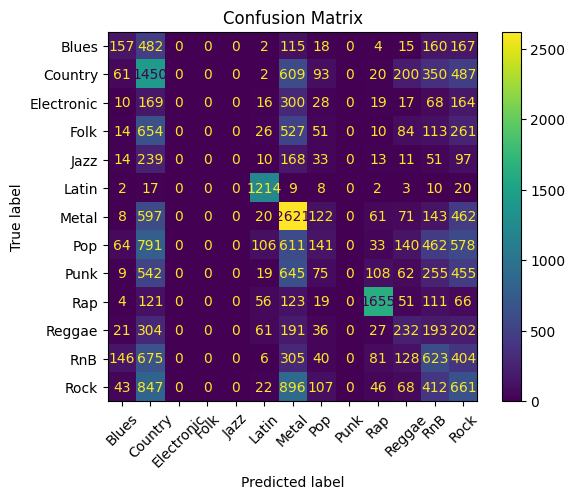

In [402]:
genre_labels = sorted(df['genre'].unique())
cm = confusion_matrix(true_genres_labels,pred_genres,labels=genre_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

<hr>

The **results** above are not so great. An accuracy of 0.32. The F1-score for a few genres show some promise, though. Latin is high, Metal is decent, Rap is high. The rest are not good. Electronic, Folk, Jazz, and Punk did not get predicted even **once**. That is not good. Below I will attempt a similar model but with **hyperparameter** tuning to see if the accuracy can be increased a bit.

#### NMF Hyperparameter Tuning

<hr>

The hyperparameters that will be iterated over are:

- **NMF: n_components** the number of topics/clusters to form
- **NMF: alpha_H** regularization parameter on the topic-word matrix
- **NMF: alpha_W** regularization parameter on the document-topic matrix
- **NMF: l1_ratio** controls the "mix" between L1 and L2 regularization. 
- **CountVectorizer: max_features** max words to use.

Parameters NOT tuned:

- **TfidfTransformer: sublinear_tf = True** This is a good default option to use for this task. This helps to dampen the dominance of super common terms while preserving importance. It applies a logarithmic scaling to term frequency.
- **TfidfTransformer: norm = 'l2'**: This is the best option when focusing on cosine similarity based clustering such as Non-Negative Matrix Factorization, as this task is using. This option scales vectors so their euclidean norm is 1.
- **NMF: init = 'nndsvd'**: This provides a good initiliazation starting point for the NMF. It improves convergence speed and final results. 

In [403]:
#This takes a VERY long time. After running it, I added a line to make it converge quickly for future runs. Undo this if you want to do
#the optimization again!
#param_grid = {'n_components':[13,20,30,40],'max_features':[1000,2000,3000],'alpha_H':[0.0,0.1],'alpha_W':[0.0,0.1],'l1_ratio':[0.0,0.5]}
param_grid = {'n_components':[20],'max_features':[1000],'alpha_H':[0.0],'alpha_W':[0.0],'l1_ratio':[0.0]}
best_score = 0
best_configuration = {}
best_genre_labels = []


for n in param_grid['n_components']:
    for max_feature in param_grid['max_features']:
        for alpha_W in param_grid['alpha_W']:
            for alpha_H in param_grid['alpha_H']:
                for l1 in param_grid['l1_ratio']:
                    #create the current model with parametrs used
                    vectorizer = CountVectorizer(stop_words = 'english',max_features = max_feature)
                    X_counts = vectorizer.fit_transform(df['lyrics'])
                    tfidf = TfidfTransformer(sublinear_tf = True, norm ='l2')
                    X_tfidf = tfidf.fit_transform(X_counts)
                    nmf = NMF(n_components=n, init = 'nndsvd', max_iter = 1500,alpha_W=alpha_W,alpha_H=alpha_H,l1_ratio=l1)
                    X_nmf = nmf.fit_transform(X_tfidf)
    
                    #predict genres 
                    top_res = X_nmf.argmax(axis=1)
                    comp_labels = []
                    for i in range(n):
                        topic_genres = df['genre'][top_res==i]
                        if not topic_genres.empty:
                            label = topic_genres.mode()[0]
                        else:
                            label = "Unlabeled Genre"
                        comp_labels.append(label)
                    pred_genres = []
                    for topic_idx in top_res:
                        pred_genres.append(comp_labels[topic_idx])
    
                    acc = accuracy_score(df['genre'],pred_genres)
                    #compare accuracies across the runs
                    if acc > best_score:
                        best_score = acc
                        best_configuration = {'n_components':n,'max_features':max_feature,'alpha_W':alpha_W,'alpha_H':alpha_H,'l1_ratio':l1}
                        best_genre_labels = pred_genres
print("The best results are:")
print(best_configuration)
print("Accuracy ",best_score)

The best results are:
{'n_components': 20, 'max_features': 1000, 'alpha_W': 0.0, 'alpha_H': 0.0, 'l1_ratio': 0.0}
Accuracy  0.3304351043362439


In [404]:
best_n_components = best_configuration['n_components']
best_alpha_H= best_configuration['alpha_H']
best_alpha_W = best_configuration['alpha_W']
best_l1_ratio = best_configuration['l1_ratio']
best_max_features = best_configuration['max_features']
all_accuracies = []
filt_accuracies = []
all_accuracies.append(best_score)

#### K-fold Test
Will perform a K-fold run with 5 folds on the data and see if there's a subset of data the gives a high accuracy.

In [405]:
kf = KFold(n_splits = 5, shuffle=True,random_state =42)
for fold_index, (train_index,test_index) in enumerate(kf.split(df)):
    print(f'Fold Number {fold_index+1}')
    df_train,df_test = df.iloc[train_index],df.iloc[test_index]
    vectorizer=CountVectorizer(stop_words='english',max_features=best_max_features)
    X_train_counts = vectorizer.fit_transform(df_train['lyrics'])
    tfidf=TfidfTransformer(sublinear_tf=True, norm='l2')
    X_train_tfidf = tfidf.fit_transform(X_train_counts)
    nmf_model = NMF(n_components=best_n_components,init='nndsvd',max_iter=1000,random_state=42,alpha_H=best_alpha_H,alpha_W=best_alpha_W,l1_ratio=best_l1_ratio)
    X_train_nmf = nmf_model.fit_transform(X_train_tfidf)
    top_res = X_train_nmf.argmax(axis=1)

    #Find majority label and assign the correct genre to it
    comp_labels = []
    for i in range(best_n_components):
        topic_genres = df_train['genre'][top_res==i]
        if not topic_genres.empty:
            label = topic_genres.mode()[0]
        else:
            label = "Unlabeled Genre"
        comp_labels.append(label)
    pred_genres = []
    for topic_idx in top_res:
        pred_genres.append(comp_labels[topic_idx])
    true_genres_labels = df_train['genre']
    acc = accuracy_score(true_genres_labels,pred_genres)
    print(f'Accuracy for fold {fold_index+1} is {acc}')

Fold Number 1
Accuracy for fold 1 is 0.33299417260197944
Fold Number 2
Accuracy for fold 2 is 0.33748034409397837
Fold Number 3
Accuracy for fold 3 is 0.33433539913051524
Fold Number 4
Accuracy for fold 4 is 0.33242380798224114
Fold Number 5
Accuracy for fold 5 is 0.33663228969153214


Not any significant gains from doing this.

In [406]:
#this is for tracking the F1-score and other stuff i will display later in the report
vectorizer = CountVectorizer(stop_words='english', max_features=best_max_features)
X_counts = vectorizer.fit_transform(df['lyrics'])
tfidf = TfidfTransformer(sublinear_tf=True, norm='l2')
X_tfidf = tfidf.fit_transform(X_counts)
n_components = best_n_components
nmf_model = NMF(n_components=n_components, init='nndsvd', max_iter=1000, random_state=42,alpha_H=best_alpha_H,alpha_W=best_alpha_W,l1_ratio=best_l1_ratio)
X_nmf = nmf_model.fit_transform(X_tfidf)

top_res = X_nmf.argmax(axis=1)

#Find majority label and assign the correct genre to it
comp_labels = []
for i in range(n_components):
    topic_genres = df['genre'][top_res==i]
    if not topic_genres.empty:
        label = topic_genres.mode()[0]
    else:
        label = "Unlabeled Genre"
    comp_labels.append(label)
pred_genres = []
for topic_idx in top_res:
    pred_genres.append(comp_labels[topic_idx])

#results
true_genres_labels = df['genre']
#acc = accuracy_score(true_genres_labels,pred_genres)
#print(f'Accuracy is {acc:.03f}')
#print(classification_report(true_genres_labels,pred_genres,zero_division=0))
report_nmf_all = classification_report(true_genres_labels,pred_genres,output_dict=True,zero_division = 0)

Best accuracy attained after **hyperparameter tuning** is ~0.34 (not much of an improvement). n_components = 20, max_features = 1000, alpha_W = 0, alpha_H = 0, l1_ratio = 0.5. I will use these parameters in future work / attempts utilizing TfidfTransformer and NMF.
Doing a 5 fold k-fold did not produce any insights, either.

#### NMF (Less Genres)
I will attempt creating a model again but with less genres. As discussed prior, it would be difficult to create a model with high accuracy since the similarities for many of the genres are so high. I will create a new dataframe that is comprised of the 4 genres with the least amount of similarity between them, Latin, Rap, Metal, and Pop, and then test how good the model is. For this modelling task, the number of n_components will be optimized but the other parameters from before will not.

In [407]:
df_filtered = df[df["genre"].isin(['Latin','Rap','Metal','Pop'])].copy()

In [408]:
#This takes a VERY long time. After running it, I added a line to make it converge quickly for future runs. Undo this if you want to do
#the optimization again!
#param_grid = {'n_components':[4,5,6,7],'max_features':[1000],'alpha_H':[0.0],'alpha_W':[0.0],'l1_ratio':[0.0]}
param_grid = {'n_components':[4],'max_features':[1000],'alpha_H':[0.0],'alpha_W':[0.0],'l1_ratio':[0.0]}
best_NMF_2_score = 0
best_NMF_2_configuration = {}
best_NMF_2_genre_labels = []


for n in param_grid['n_components']:
    for max_feature in param_grid['max_features']:
        for alpha_W in param_grid['alpha_W']:
            for alpha_H in param_grid['alpha_H']:
                for l1 in param_grid['l1_ratio']:
                    #create the current model with parametrs used
                    vectorizer = CountVectorizer(stop_words = 'english',max_features = max_feature)
                    X_counts = vectorizer.fit_transform(df_filtered['lyrics'])
                    tfidf = TfidfTransformer(sublinear_tf = True, norm ='l2')
                    X_tfidf = tfidf.fit_transform(X_counts)
                    nmf = NMF(n_components=n, init = 'nndsvd', max_iter = 1500,alpha_W=alpha_W,alpha_H=alpha_H,l1_ratio=l1)
                    X_nmf = nmf.fit_transform(X_tfidf)
    
                    #predict genres 
                    top_res = X_nmf.argmax(axis=1)
                    comp_labels = []
                    for i in range(n):
                        topic_genres = df_filtered['genre'][top_res==i]
                        if not topic_genres.empty:
                            label = topic_genres.mode()[0]
                        else:
                            label = "Unlabeled Genre"
                        comp_labels.append(label)
                    pred_genres = []
                    for topic_idx in top_res:
                        pred_genres.append(comp_labels[topic_idx])
    
                    acc = accuracy_score(df_filtered['genre'],pred_genres)
                    #compare accuracies across the runs
                    if acc > best_NMF_2_score:
                        best_NMF_2_score = acc
                        best_NMF_2_configuration = {'n_components':n,'max_features':max_feature,'alpha_W':alpha_W,'alpha_H':alpha_H,'l1_ratio':l1}
                        best_NMF_2_genre_labels = pred_genres
print("The best results are:")
print(best_NMF_2_configuration)
print("Accuracy ",best_NMF_2_score)

The best results are:
{'n_components': 4, 'max_features': 1000, 'alpha_W': 0.0, 'alpha_H': 0.0, 'l1_ratio': 0.0}
Accuracy  0.8007032883482228


In [409]:
best_NMF_2_components = best_NMF_2_configuration['n_components']

In [410]:
#model training
vectorizer = CountVectorizer(stop_words='english', max_features=best_max_features)
X_counts = vectorizer.fit_transform(df_filtered['lyrics'])
tfidf = TfidfTransformer(sublinear_tf=True, norm='l2')
X_tfidf = tfidf.fit_transform(X_counts)
n_components = best_NMF_2_components
nmf_model = NMF(n_components=n_components, init='nndsvd', max_iter=1000, random_state=42,alpha_H=best_alpha_H,alpha_W=best_alpha_W,l1_ratio=best_l1_ratio)
X_nmf = nmf_model.fit_transform(X_tfidf)

top_res = X_nmf.argmax(axis=1)

#Find majority label and assign the correct genre to it
comp_labels = []
for i in range(n_components):
    topic_genres = df_filtered['genre'][top_res==i]
    if not topic_genres.empty:
        label = topic_genres.mode()[0]
    else:
        label = "Unlabeled Genre"
    comp_labels.append(label)
pred_genres = []
for topic_idx in top_res:
    pred_genres.append(comp_labels[topic_idx])

#results
true_genres_labels = df_filtered['genre']
acc = accuracy_score(true_genres_labels,pred_genres)
print(f'Accuracy is {acc:.03f}')
print(classification_report(true_genres_labels,pred_genres,zero_division=0))
report_nmf_filt = classification_report(true_genres_labels,pred_genres,output_dict=True,zero_division = 0)
filt_accuracies.append(acc)

Accuracy is 0.801
              precision    recall  f1-score   support

       Latin       0.84      0.95      0.89      1285
       Metal       0.86      0.76      0.81      4105
         Pop       0.70      0.77      0.73      2926
         Rap       0.83      0.83      0.83      2206

    accuracy                           0.80     10522
   macro avg       0.81      0.83      0.81     10522
weighted avg       0.81      0.80      0.80     10522



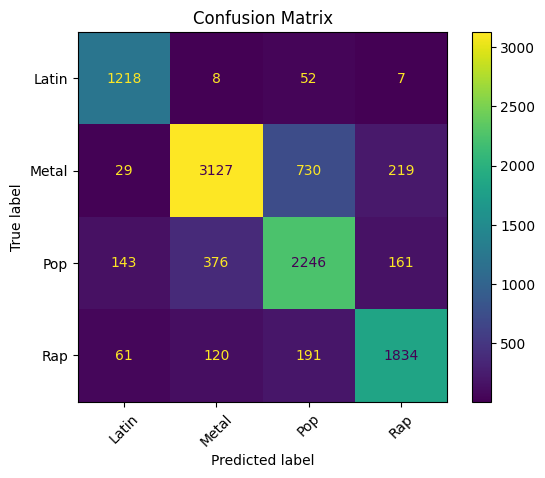

In [411]:
genre_labels = sorted(df_filtered['genre'].unique())
cm = confusion_matrix(true_genres_labels,pred_genres,labels=genre_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

These results are much better. An overall accuracy of **0.80** and reasonably high F1-scores in the genres as well. 

### K-Means Modelling Attempt
Will attempt to use a different type of model, K-means. K-means is a simpler model that requires the number of clusters you expect, which is exactly what we have since we know the genres we want to cluster into.

In [412]:
#initial tfidf is same as before
vectorizer = CountVectorizer(stop_words='english', max_features=best_max_features)
X_counts = vectorizer.fit_transform(df['lyrics'])
tfidf = TfidfTransformer(sublinear_tf=True, norm='l2')
X_tfidf = tfidf.fit_transform(X_counts)

#setup kmeans
n_cluster = len(df['genre'].unique())
kmeans=  KMeans(n_clusters=n_cluster,random_state=42,n_init=10)
kmeans.fit(X_tfidf)

df['kmeans clusters'] = kmeans.labels_
cluster_genre = {}
for cluster in range(n_cluster):
    labels = df['genre'][df['kmeans clusters']==cluster]
    if not labels.empty:
        cluster_genre[cluster] = labels.mode()[0]
    else:
        cluster_genre[cluster] = "Unlabeled Genre"
#
df['pred kmeans']=df['kmeans clusters'].map(cluster_genre)

acc = accuracy_score(df['genre'],df['pred kmeans'])
print(f'Kmeans accuracy is {acc:.03f}')
print(classification_report(df['genre'],df['pred kmeans'],zero_division=0))
report_kmeans_all = classification_report(df['genre'],df['pred kmeans'],output_dict=True,zero_division = 0)
all_accuracies.append(acc)

Kmeans accuracy is 0.357
              precision    recall  f1-score   support

       Blues       0.00      0.00      0.00      1120
     Country       0.25      0.54      0.34      3272
  Electronic       0.00      0.00      0.00       791
        Folk       0.00      0.00      0.00      1740
        Jazz       0.00      0.00      0.00       636
       Latin       0.89      0.91      0.90      1285
       Metal       0.35      0.78      0.48      4105
         Pop       0.33      0.03      0.05      2926
        Punk       0.00      0.00      0.00      2170
         Rap       0.90      0.69      0.78      2206
      Reggae       0.73      0.13      0.22      1267
         RnB       0.33      0.43      0.37      2408
        Rock       0.17      0.23      0.20      3102

    accuracy                           0.36     27028
   macro avg       0.30      0.29      0.26     27028
weighted avg       0.32      0.36      0.29     27028



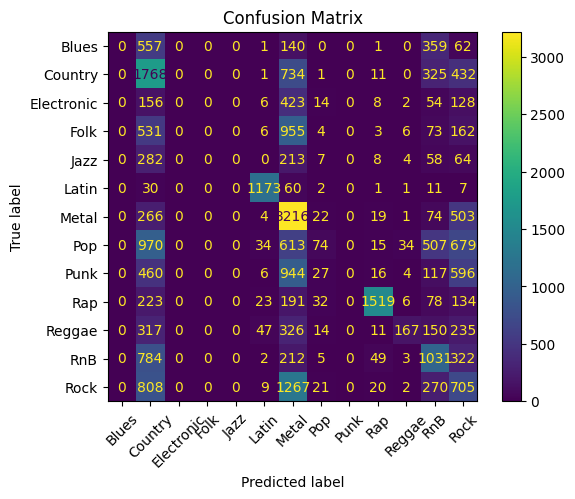

In [413]:
genre_labels = sorted(df['genre'].unique())
cm = confusion_matrix(df['genre'],df['pred kmeans'],labels=genre_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

<hr>

The KMeans results are a little better than NMF. The accuracy is 0.36. The resulting confusion matrix does not look much better than before. Some genres still do not get predicted once: Blues, Electronic, Jazz, Rock. Probably due to such strong overlap between the genres.

#### KMeans (Less Genres)
Similar to the above NMF, we will attempt to model just Rap, Pop, Latin, and Metal and see how well the results turn out.

In [414]:
#initial tfidf is same as before
vectorizer = CountVectorizer(stop_words='english', max_features=best_max_features)
X_counts = vectorizer.fit_transform(df_filtered['lyrics'])
tfidf = TfidfTransformer(sublinear_tf=True, norm='l2')
X_tfidf = tfidf.fit_transform(X_counts)

#setup kmeans
n_cluster = len(df_filtered['genre'].unique())
kmeans=  KMeans(n_clusters=n_cluster,random_state=42,n_init=10)
kmeans.fit(X_tfidf)

df_filtered['kmeans clusters'] = kmeans.labels_
cluster_genre = {}
for cluster in range(n_cluster):
    labels = df_filtered['genre'][df_filtered['kmeans clusters']==cluster]
    if not labels.empty:
        cluster_genre[cluster] = labels.mode()[0]
    else:
        cluster_genre[cluster] = "Unlabeled Genre"
#
df_filtered['pred kmeans']=df_filtered['kmeans clusters'].map(cluster_genre)

acc = accuracy_score(df_filtered['genre'],df_filtered['pred kmeans'])
print(f'Kmeans accuracy is {acc:.03f}')
print(classification_report(df_filtered['genre'],df_filtered['pred kmeans'],zero_division=0))
report_kmeans_filt = classification_report(df_filtered['genre'],df_filtered['pred kmeans'],output_dict=True,zero_division = 0)
filt_accuracies.append(acc)

Kmeans accuracy is 0.811
              precision    recall  f1-score   support

       Latin       0.92      0.92      0.92      1285
       Metal       0.81      0.82      0.81      4105
         Pop       0.69      0.78      0.73      2926
         Rap       0.95      0.78      0.86      2206

    accuracy                           0.81     10522
   macro avg       0.84      0.82      0.83     10522
weighted avg       0.82      0.81      0.81     10522



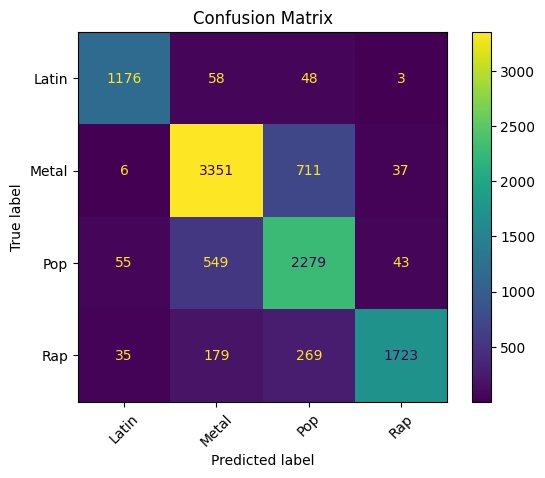

In [415]:
genre_labels = sorted(df_filtered['genre'].unique())
cm = confusion_matrix(df_filtered['genre'],df_filtered['pred kmeans'],labels=genre_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

KMeans produces an accuracy of **0.81**. This is pretty good. High F1-scores for all the genres.

### LDA Model Attempt 
Will attempt to do this task with Latent Dirichlet Allocation modelling as well. The LDA hyperparameters will be optimized with something similar to a gridsearch method. These are:

- **n_components**: number of topics. How many topics the model is discovering.
- **doc_topic_prior**: Controls the sparsity of topic distribution in each song

In [416]:
#Similar to the NMF, once the best results were found I commented the gridsearch. Uncomment this when wanting to optimize again. 
#This notebook took ~30 minutes to run and I'm sure 15 and 15 of that is this section and the NMF optimization section.
#param_grid = {'n_components':[10,13,15,20],'doc_topic_prior':[None,0.1,0.01]}
param_grid = {'n_components':[15],'doc_topic_prior':[0.1]}
best_LDA_score = 0
best_LDA_configuration = {}
best_LDA_genre_labels = []

for n in param_grid['n_components']:
    for dtp in param_grid['doc_topic_prior']:
        vectorizer = CountVectorizer(stop_words='english', max_features=best_max_features)
        X_counts = vectorizer.fit_transform(df['lyrics'])
        n_topics = n
        lda = LatentDirichletAllocation(n_components=n, max_iter=10, learning_method='online', random_state=42,doc_topic_prior=dtp)
        X_lda = lda.fit_transform(X_counts)
        
        top_res = X_lda.argmax(axis=1)
        
        #find majority label
        comp_labels = {}
        for i in range(n_topics):
            topic_genres = df['genre'][top_res == i]
            if not topic_genres.empty:
                comp_labels[i] = topic_genres.mode()[0]
            else:
                comp_labels[i] = "Unlabeled Genre"
        
        pred_genres = []
        for topic_idx in top_res:
            pred_genres.append(comp_labels[topic_idx])

        acc = accuracy_score(df['genre'],pred_genres)
        #compare accuracies across the runs
        if acc > best_LDA_score:
            best_LDA_score = acc
            best_LDA_configuration = {'n_components':n,'doc_topic_prior':dtp}
            best_LDA_genre_labels = pred_genres


print("The best results are:")
print(best_LDA_configuration)
print("Accuracy ",best_LDA_score)

The best results are:
{'n_components': 15, 'doc_topic_prior': 0.1}
Accuracy  0.3185955305608998


In [417]:
best_n_components = best_LDA_configuration['n_components']
best_doc_topic_prior = best_LDA_configuration['doc_topic_prior']
all_accuracies.append(best_LDA_score)

In [418]:

vectorizer = CountVectorizer(stop_words='english', max_features=best_max_features)
X_counts = vectorizer.fit_transform(df['lyrics'])
n_topics = best_n_components 
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=42,doc_topic_prior=best_doc_topic_prior)
X_lda = lda.fit_transform(X_counts)

top_res = X_lda.argmax(axis=1)

#find majority label
comp_labels = {}
for i in range(n_topics):
    topic_genres = df['genre'][top_res == i]
    if not topic_genres.empty:
        comp_labels[i] = topic_genres.mode()[0]
    else:
        comp_labels[i] = "Unlabeled Genre"

pred_genres = []
for topic_idx in top_res:
    pred_genres.append(comp_labels[topic_idx])

#results
true_genres_labels = df['genre']
acc = accuracy_score(true_genres_labels, pred_genres)
print(f"Accuracy for LDA is: {acc:.03f}")
print(classification_report(true_genres_labels, pred_genres, zero_division=0))
report_lda_all = classification_report(true_genres_labels, pred_genres, output_dict=True, zero_division=0)

Accuracy for LDA is: 0.319
              precision    recall  f1-score   support

       Blues       0.00      0.00      0.00      1120
     Country       0.22      0.28      0.25      3272
  Electronic       0.00      0.00      0.00       791
        Folk       0.20      0.18      0.19      1740
        Jazz       0.00      0.00      0.00       636
       Latin       0.70      0.95      0.81      1285
       Metal       0.52      0.67      0.58      4105
         Pop       0.17      0.48      0.25      2926
        Punk       0.00      0.00      0.00      2170
         Rap       0.41      0.71      0.52      2206
      Reggae       0.00      0.00      0.00      1267
         RnB       0.24      0.09      0.13      2408
        Rock       0.18      0.08      0.11      3102

    accuracy                           0.32     27028
   macro avg       0.20      0.26      0.22     27028
weighted avg       0.24      0.32      0.26     27028



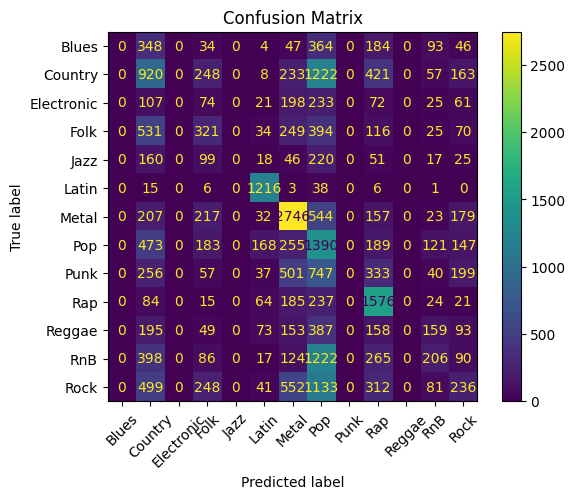

In [419]:
genre_labels = sorted(df['genre'].unique())
cm = confusion_matrix(true_genres_labels,pred_genres,labels=genre_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

LDA is not much better than NMF or K-means. This clustering problem is difficult with overlapping genres.

#### LDA (Less Genres)
Will model the genre clustering problem using the smaller dataset with only 4 genres: Rap, Pop, Metal, and Latin. We will optimize the n-components value by testing different values and then report the accuracy obtained.

In [420]:
#Uncomment if you want to optimize again. Commenting it for future runs to converge quickly
#param_grid = {'n_components':[4,5,6,7]}
param_grid = {'n_components':[6]}
best_LDAL_score = 0
best_LDAL_configuration = {}
best_LDAL_genre_labels = []

for n in param_grid['n_components']:
    vectorizer = CountVectorizer(stop_words='english', max_features=best_max_features)
    X_counts = vectorizer.fit_transform(df_filtered['lyrics'])
    n_topics = n
    lda = LatentDirichletAllocation(n_components=n, max_iter=10, learning_method='online', random_state=42,doc_topic_prior=0.1)
    X_lda = lda.fit_transform(X_counts)
    
    top_res = X_lda.argmax(axis=1)
    
    #find majority label
    comp_labels = {}
    for i in range(n_topics):
        topic_genres = df_filtered['genre'][top_res == i]
        if not topic_genres.empty:
            comp_labels[i] = topic_genres.mode()[0]
        else:
            comp_labels[i] = "Unlabeled Genre"
    
    pred_genres = []
    for topic_idx in top_res:
        pred_genres.append(comp_labels[topic_idx])

    acc = accuracy_score(df_filtered['genre'],pred_genres)
    #compare accuracies across the runs
    if acc > best_LDAL_score:
        best_LDAL_score = acc
        best_LDAL_configuration = {'n_components':n}
        best_LDAL_genre_labels = pred_genres


print("The best results are:")
print(best_LDAL_configuration)
print("Accuracy ",best_LDAL_score)

The best results are:
{'n_components': 6}
Accuracy  0.8076411328644745


In [421]:
best_LDAL_n_components = best_LDAL_configuration['n_components']

In [422]:
vectorizer = CountVectorizer(stop_words='english', max_features=best_max_features)
X_counts = vectorizer.fit_transform(df_filtered['lyrics'])
n_topics = best_LDAL_n_components 
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=42)
X_lda = lda.fit_transform(X_counts)

top_res = X_lda.argmax(axis=1)

#find majority label
comp_labels = {}
for i in range(n_topics):
    topic_genres = df_filtered['genre'][top_res == i]
    if not topic_genres.empty:
        comp_labels[i] = topic_genres.mode()[0]
    else:
        comp_labels[i] = "Unlabeled Genre"

pred_genres = []
for topic_idx in top_res:
    pred_genres.append(comp_labels[topic_idx])

#results
true_genres_labels = df_filtered['genre']
acc = accuracy_score(true_genres_labels, pred_genres)
print(f"LDA Accuracy is: {acc:.03f}")
print(classification_report(true_genres_labels, pred_genres, zero_division=0))
report_lda_filt = classification_report(true_genres_labels, pred_genres, output_dict=True, zero_division=0)
filt_accuracies.append(acc)

LDA Accuracy is: 0.805
              precision    recall  f1-score   support

       Latin       0.91      0.94      0.93      1285
       Metal       0.82      0.83      0.82      4105
         Pop       0.72      0.73      0.72      2926
         Rap       0.84      0.79      0.81      2206

    accuracy                           0.80     10522
   macro avg       0.82      0.82      0.82     10522
weighted avg       0.81      0.80      0.80     10522



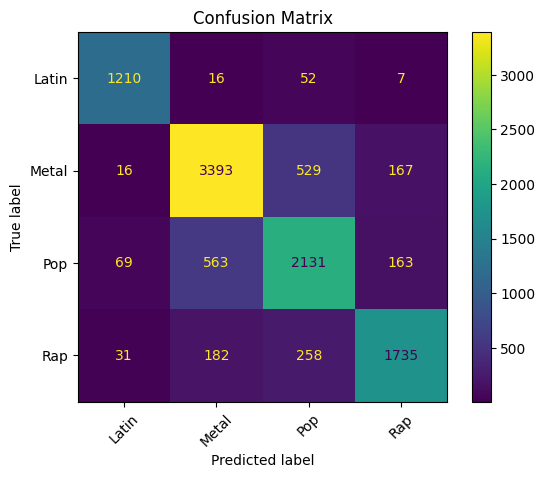

In [423]:
genre_labels = sorted(df_filtered['genre'].unique())
cm = confusion_matrix(true_genres_labels,pred_genres,labels=genre_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

The LDA model using the shortened dataset also produces a good accuracy of **0.81**.

### Logistic Regression (Supervised Method)
I will now use a supervised method just to compare the results to unsupervised method results. For this, I will do the typical 20/80 test/train data split.

In [424]:
from sklearn.model_selection import train_test_split
#split the data
X = df['lyrics']
y = df['genre']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

#Tfidf the lyrics
vectorizer = CountVectorizer(stop_words='english', max_features=best_max_features)
X_counts = vectorizer.fit_transform(X_train)
tfidf = TfidfTransformer(sublinear_tf=True, norm='l2')
X_tfidf = tfidf.fit_transform(X_counts)
LR = LogisticRegression(max_iter = 2000)
LR.fit(X_tfidf,y_train)
X_test = vectorizer.transform(X_test)
X_test_tfidf = tfidf.transform(X_test)
y_pred = LR.predict(X_test_tfidf)

##accuracy
acc = accuracy_score(y_test,y_pred)
print(f'Accuracy from LR is {acc:.03f}')
print(classification_report(y_test,y_pred, zero_division=0))
report_lr_all = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
all_accuracies.append(acc)


Accuracy from LR is 0.510
              precision    recall  f1-score   support

       Blues       0.65      0.52      0.58       224
     Country       0.48      0.62      0.54       655
  Electronic       0.12      0.01      0.01       158
        Folk       0.42      0.33      0.37       348
        Jazz       0.41      0.09      0.14       127
       Latin       0.88      0.94      0.91       257
       Metal       0.57      0.78      0.66       821
         Pop       0.34      0.35      0.35       585
        Punk       0.43      0.39      0.41       434
         Rap       0.86      0.78      0.82       441
      Reggae       0.71      0.30      0.42       253
         RnB       0.49      0.55      0.52       482
        Rock       0.27      0.28      0.27       621

    accuracy                           0.51      5406
   macro avg       0.51      0.46      0.46      5406
weighted avg       0.50      0.51      0.49      5406



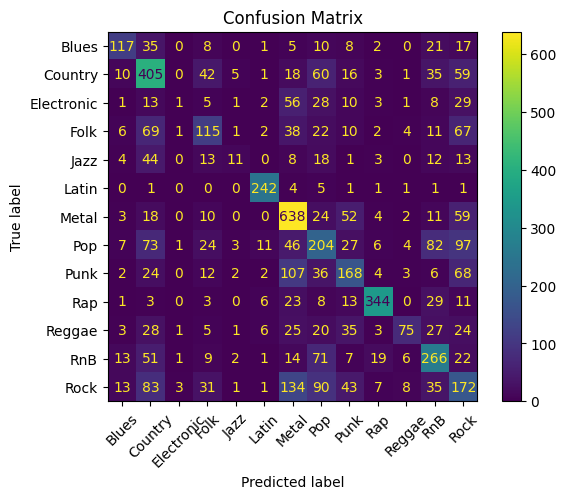

In [425]:
genre_labels = sorted(df['genre'].unique())
cm = confusion_matrix(y_test,y_pred,labels=genre_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

The logistic regression accuracy on the test data is pretty good (**0.51**), considering how low the unsupervised methods were. Still not great.

#### Logistic Regression (Less Genres)
Similar to the unsupervised models, we will see the results for Logistic Regression when only using a subset of the data with 4 genres: Rap, Latin, Metal, Pop. This is done using a 20/80 test/train split to validate the results.

In [426]:
from sklearn.model_selection import train_test_split
#split the data
X = df_filtered['lyrics']
y = df_filtered['genre']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

#Tfidf the lyrics
vectorizer = CountVectorizer(stop_words='english', max_features=best_max_features)
X_counts = vectorizer.fit_transform(X_train)
tfidf = TfidfTransformer(sublinear_tf=True, norm='l2')
X_tfidf = tfidf.fit_transform(X_counts)
LR = LogisticRegression(max_iter = 2000)
LR.fit(X_tfidf,y_train)
X_test = vectorizer.transform(X_test)
X_test_tfidf = tfidf.transform(X_test)
y_pred = LR.predict(X_test_tfidf)

##accuracy
acc = accuracy_score(y_test,y_pred)
print(f'Accuracy from LR is {acc:.03f}')
print(classification_report(y_test,y_pred, zero_division=0))
report_lr_filt = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
filt_accuracies.append(acc)

Accuracy from LR is 0.875
              precision    recall  f1-score   support

       Latin       0.94      0.97      0.96       257
       Metal       0.85      0.91      0.88       821
         Pop       0.82      0.80      0.81       586
         Rap       0.95      0.85      0.90       441

    accuracy                           0.87      2105
   macro avg       0.89      0.88      0.89      2105
weighted avg       0.88      0.87      0.87      2105



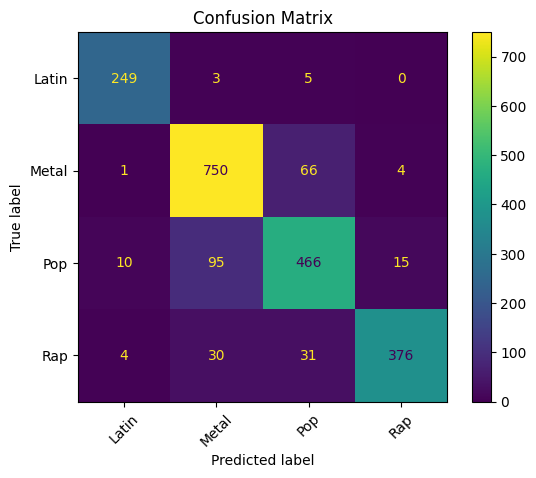

In [427]:
genre_labels = sorted(df_filtered['genre'].unique())
cm = confusion_matrix(y_test,y_pred,labels=genre_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

On the reduced dataset, Logistic Regression produces a model with an accuracy of **0.88**! The best so far but that is expected since it is fitting parameters with an end-target (the genre labels).

## Summarized Results

The parameters used for each of the models used is shown below. Hyperparameters for NMF and LDA were optimized using a gridsearch method based on the highest accuracy attained for every combination of parameter values. This was done for the all-genres case and the reduced genres case.

- Tfidf-Transformer
-  - max_features: 1000
- NMF
-  - n_components: 20 (all genre case), 4 (4 genre case)
   - alpha_W : 0
   - alpha_H : 0
   - l1_ratio : 0.5
- KMeans
-  - n_cluster : equal to number of genres. 13 (all genres), 4 (4 genres)
- LDA
- - n_topics : 20 for the all genre case. 4 for the 4 genre case. 

A summary of the results for each of the models is shown below. The metrics used for comparison are F1-score, recall, and accuracy. These are each shown for the models developed with ALL of the genres and then the models developed with only a subset of genres (Latin, Metal, Pop, Rap).


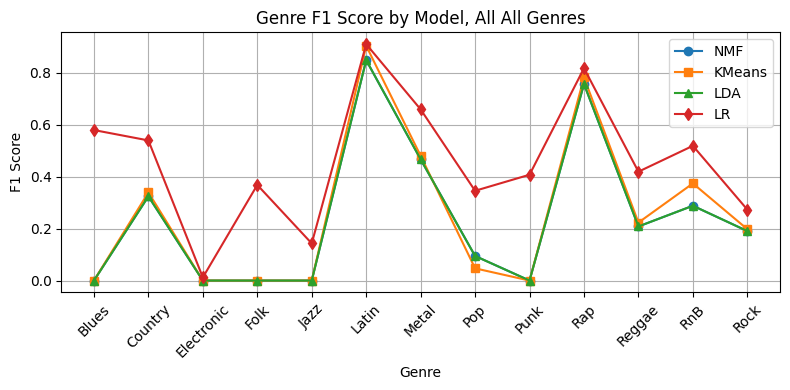

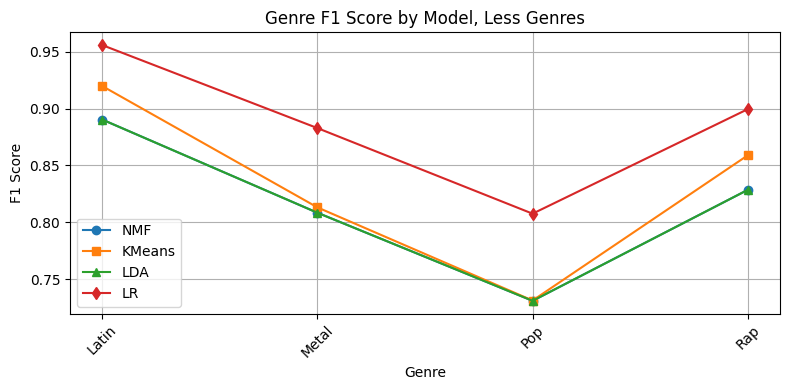

In [428]:
unique_genres_all = df['genre'].unique()
unique_genres_filt = df_filtered['genre'].unique()

genres_all = []
for label in report_nmf_all:
    if label in unique_genres_all:
        genres_all.append(label)
genres_filt = []
for label in report_nmf_filt:
    if label in unique_genres_filt:
        genres_filt.append(label)

f1_nmf_all = []
f1_kmeans_all = []
f1_lda_all = []
f1_lr_all = []
for genre in genres_all:
    f1_nmf_all.append(report_nmf_all[genre]['f1-score'])
    f1_kmeans_all.append(report_kmeans_all[genre]['f1-score'])
    f1_lda_all.append(report_nmf_all[genre]['f1-score'])
    f1_lr_all.append(report_lr_all[genre]['f1-score'])
f1_nmf_filt = []
f1_kmeans_filt = []
f1_lda_filt = []
f1_lr_filt = []
for genre in genres_filt:
    f1_nmf_filt.append(report_nmf_filt[genre]['f1-score'])
    f1_kmeans_filt.append(report_kmeans_filt[genre]['f1-score'])
    f1_lda_filt.append(report_nmf_filt[genre]['f1-score'])
    f1_lr_filt.append(report_lr_filt[genre]['f1-score'])

plt.figure(figsize=(8,4))
plt.plot(genres_all,f1_nmf_all,marker='o',label="NMF")
plt.plot(genres_all,f1_kmeans_all,marker='s',label="KMeans")
plt.plot(genres_all,f1_lda_all,marker='^',label="LDA")
plt.plot(genres_all,f1_lr_all,marker='d',label="LR")
plt.title('Genre F1 Score by Model, All All Genres')
plt.xlabel('Genre')
plt.ylabel('F1 Score')
#plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(genres_filt,f1_nmf_filt,marker='o',label="NMF")
plt.plot(genres_filt,f1_kmeans_filt,marker='s',label="KMeans")
plt.plot(genres_filt,f1_lda_filt,marker='^',label="LDA")
plt.plot(genres_filt,f1_lr_filt,marker='d',label="LR")
plt.title('Genre F1 Score by Model, Less Genres')
plt.xlabel('Genre')
plt.ylabel('F1 Score')
#plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

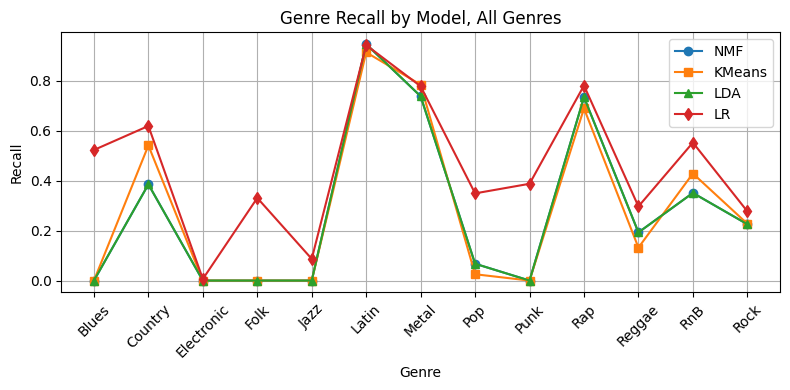

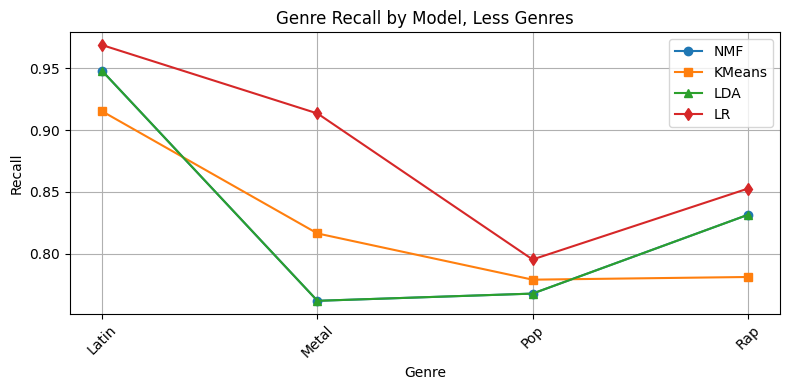

In [429]:
recall_nmf_all = []
recall_kmeans_all = []
recall_lda_all = []
recall_lr_all = []
for genre in genres_all:
    recall_nmf_all.append(report_nmf_all[genre]['recall'])
    recall_kmeans_all.append(report_kmeans_all[genre]['recall'])
    recall_lda_all.append(report_nmf_all[genre]['recall'])
    recall_lr_all.append(report_lr_all[genre]['recall'])
recall_nmf_filt = []
recall_kmeans_filt = []
recall_lda_filt = []
recall_lr_filt = []
for genre in genres_filt:
    recall_nmf_filt.append(report_nmf_filt[genre]['recall'])
    recall_kmeans_filt.append(report_kmeans_filt[genre]['recall'])
    recall_lda_filt.append(report_nmf_filt[genre]['recall'])
    recall_lr_filt.append(report_lr_filt[genre]['recall'])

plt.figure(figsize=(8,4))
plt.plot(genres_all,recall_nmf_all,marker='o',label="NMF")
plt.plot(genres_all,recall_kmeans_all,marker='s',label="KMeans")
plt.plot(genres_all,recall_lda_all,marker='^',label="LDA")
plt.plot(genres_all,recall_lr_all,marker='d',label="LR")
plt.title('Genre Recall by Model, All Genres')
plt.xlabel('Genre')
plt.ylabel('Recall')
#plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(genres_filt,recall_nmf_filt,marker='o',label="NMF")
plt.plot(genres_filt,recall_kmeans_filt,marker='s',label="KMeans")
plt.plot(genres_filt,recall_lda_filt,marker='^',label="LDA")
plt.plot(genres_filt,recall_lr_filt,marker='d',label="LR")
plt.title('Genre Recall by Model, Less Genres')
plt.xlabel('Genre')
plt.ylabel('Recall')
#plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Accuracy')

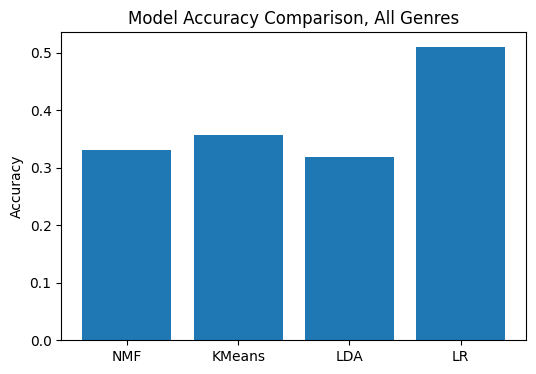

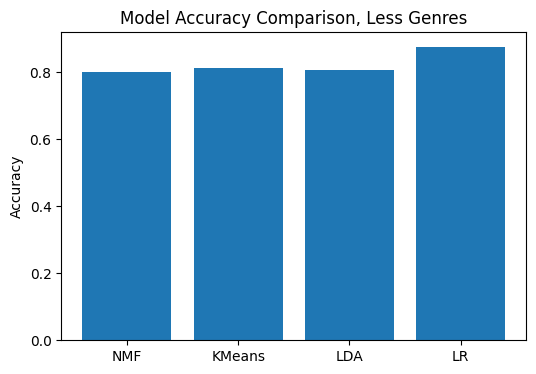

In [430]:
models = ['NMF','KMeans','LDA','LR']
plt.figure(figsize=(6,4))
plt.bar(models,all_accuracies)
plt.title('Model Accuracy Comparison, All Genres')
plt.ylabel('Accuracy')
plt.figure(figsize=(6,4))
plt.bar(models,filt_accuracies)
plt.title('Model Accuracy Comparison, Less Genres')
plt.ylabel('Accuracy')

In [431]:
nmf_model = NMF(n_components=n_components, init='nndsvd', max_iter=1000, random_state=42,alpha_H=best_alpha_H,alpha_W=best_alpha_W,l1_ratio=best_l1_ratio)

## Discussions and Conclusions

With the exception of the supervised model, all of the models performed equally as well. With the full genres included in the dataset, the average accuracy was around ~0.35. After pruning the genres down to just 4, the accuracy increased to ~0.8. Unsupervised methods can reasonably cluster songs by lyrics into Rap, Latin, Metal, or Pop. Latin makes sense - there's generally spanish words so that makes the clustering easy. Rap as well, there are generally more explicit words so this helps with clustering. Metal has violent themes often so again this makes the clustering pretty easy. Pop is not immediately obvious since this can sometimes be a catch-all genre for a lot of music, but in this dataset the topics of love came up often so that may be a deciding factor for Pop.

I expected NMF to perform the best but this was not the case. It is a strong method but it was not table to perform as well in this project. Optimizing the hyperparameters with this model is also very slow. NMF is good for modelling projects like this one so I feel the results are a failure due to the dataset and the clustering being difficult. 

The KMeans performed the best and was the fastest to calculate. Hyperparameters for this model were not optimized (there aren't very many) but it was not necessary with how good the results were. KMeans is a very good choice when you know each entry belongs to one specific cluster (as in this problem). It also has easy interpretability and intuitive visualization.

LDA performed about as equally as NMF did. LDA allows soft-clustering (a song can belong to multiple genres with percentages that add up to 100%; 30% Rock 70% Metal). I did optimize the hyperparameters with this method and it was the slowest model of the 3 unsupervised methods. 

I would recommend the KMeans model due to its simplicity and quick calculation. At least as a starting point this is a good model to use to get an idea of where your accuracy/results are going to be.

#### Limitations
As described previously, not having access to the full lyrics is a serious limitation for this project. The unsupervised methods all make use of TfidfTransformer and within that package is a `ngram_range` parameter which allows you to control how many words are grouped together as a feature. Instead of just considering single words, you can consider two words, three words, four words, etc in series which can help differentiate clusters from each other since each genre could use the same word frequently but there may be differences in the two word frequency. But as it is, the dataset provided is an abridged form of the lyrics given as a bag-of-words, so the order of words is lost.

Related to the above limitation, having full lyrics would also allow use of better algorithms. `BERTopic` combines contextual embeddings with clustering and topic modelling. It uses contextual language understanding to uncover genres/topics that are meaningful. "I love you" and "youre my everything" would have similar embeddings. It then uses dimensionality reduction to only preserve the key factors. Then BERTopic uses HDBSCAN to find clusters on the key factors.

Another limitation is that some genres are very similar and it might be inherent in the data that generating a high accuracy model for all of genres is not possible. Rock and Punk? Rap and RnB? The catchall genre Pop? It is reasonable that some songs blur the line a bit and are not explicitly one genre but half and half of two genres.

#### Future Improvements
Related to the limitations discussion, the best improvement would be to get access to full lyrics and then make use of the algorithms that analyze the lyrics and can understand the context and meaning of words. Unfortunately due to the nature of copyright, this might be a private project that requires scraping some data.

Besides access to full lyrics, the next best option is to develop a list of songs and genres from the public dataset personally and only use songs I feel *strongly* represent the genre. Any songs that I feel are in a gray area between genres will not be used. And then with interpreting these results, it would be reasonable to accept results that say 70% Rock, 30% metal, etc, since this is a gray area often.